# A guide Portfolio Optimization Environment

This notebook aims to provide an example of using PortfolioOptimizationEnv (or POE) to train a reinforcement learning model that learns to solve the portfolio optimization problem.

In this document, we will reproduce a famous architecture called EIIE (ensemble of identical independent evaluators), introduced in the following paper:

- Zhengyao Jiang, Dixing Xu, & Jinjun Liang. (2017). A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem. https://doi.org/10.48550/arXiv.1706.10059.

It's advisable to read it to understand the algorithm implemented in this notebook.

### Note
If you're using this environment, consider citing the following paper (in adittion to FinRL references):

- Caio Costa, & Anna Costa (2023). POE: A General Portfolio Optimization Environment for FinRL. In *Anais do II Brazilian Workshop on Artificial Intelligence in Finance* (pp. 132–143). SBC. https://doi.org/10.5753/bwaif.2023.231144.

## Installation and imports

To run this notebook in google colab, uncomment the cells below.

In [ ]:
## install finrl library
# !sudo apt install swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [ ]:
## We also need to install quantstats, because the environment uses it to plot graphs
# !pip install quantstats

In [1]:
## Hide matplotlib warnings
# import warnings
# warnings.filterwarnings('ignore')

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

#### Import the necessary code libraries

In [2]:
import torch

import numpy as np

from sklearn.preprocessing import MaxAbsScaler

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Fetch data

In his paper, *Jiang et al* creates a portfolio composed by the top-11 cryptocurrencies based on 30-days volume. Since it's not specified when this classification was done, it's difficult to reproduce, so we will use a similar approach in the Brazillian stock market:

- We select top-10 stocks from Brazillian stock market;
- For simplicity, we disconsider stocks that have missing data for the days in period 2011-01-01 to 2019-12-31 (9 years);

In [3]:
TOP_BRL = [
    "VALE3.SA", "PETR4.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "RENT3.SA", "LREN3.SA", "PRIO3.SA",
    "WEGE3.SA", "ABEV3.SA"
]

In [4]:
print(len(TOP_BRL))

portfolio_raw_df = YahooDownloader(start_date = '2011-01-01',
                                end_date = '2022-12-31',
                                ticker_list = TOP_BRL).fetch_data()
portfolio_raw_df

10


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (29780, 8)


,date,open,high,low,close,volume,tic,day
0,2011-01-03,5.221828,8.690246,8.728203,8.632311,576145,ABEV3.SA,0
1,2011-01-03,6.287580,15.700000,15.900000,15.750000,6626800,BBAS3.SA,0
2,2011-01-03,6.360589,11.774127,11.927362,11.809763,10862336,BBDC4.SA,0
3,2011-01-03,10.289105,18.067982,18.250118,18.031555,10014663,ITUB4.SA,0
4,2011-01-03,6.115661,8.510648,8.629907,8.422694,3652542,LREN3.SA,0
...,...,...,...,...,...,...,...,...
29775,2022-12-29,16.668446,24.500000,25.049999,24.990000,57901800,PETR4.SA,3
29776,2022-12-29,37.150330,37.209999,37.480000,37.250000,7890300,PRIO3.SA,3
29777,2022-12-29,50.361668,53.025078,55.776001,54.300869,8786791,RENT3.SA,3
29778,2022-12-29,77.194092,88.879997,89.949997,89.000000,40110800,VALE3.SA,3


In [5]:
portfolio_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ABEV3.SA,2978,2978,2978,2978,2978,2978,2978
BBAS3.SA,2978,2978,2978,2978,2978,2978,2978
BBDC4.SA,2978,2978,2978,2978,2978,2978,2978
ITUB4.SA,2978,2978,2978,2978,2978,2978,2978
LREN3.SA,2978,2978,2978,2978,2978,2978,2978
PETR4.SA,2978,2978,2978,2978,2978,2978,2978
PRIO3.SA,2978,2978,2978,2978,2978,2978,2978
RENT3.SA,2978,2978,2978,2978,2978,2978,2978
VALE3.SA,2978,2978,2978,2978,2978,2978,2978


### Normalize Data

We normalize the data dividing the time series of each stock by its maximum value, so that the dataframe contains values between 0 and 1.

In [6]:
portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(portfolio_raw_df)
portfolio_norm_df

/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/preprocessor/preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.00200262 0.00114137 0.0010422  ... 0.04565734 0.05214546 0.07760399]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/preprocessor/preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.   0.25 0.5  ... 0.25 0.5  0.75]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, sel

,date,open,high,low,close,volume,tic,day
0,2011-01-03,0.269795,0.358065,0.355383,0.353928,0.002003,ABEV3.SA,0.00
1,2011-01-03,0.320289,0.569047,0.568771,0.566547,0.014581,BBAS3.SA,0.00
2,2011-01-03,0.284425,0.397649,0.397479,0.396939,0.021760,BBDC4.SA,0.00
3,2011-01-03,0.332196,0.455228,0.458661,0.466293,0.062331,ITUB4.SA,0.00
4,2011-01-03,0.126038,0.155025,0.157120,0.153498,0.072591,LREN3.SA,0.00
...,...,...,...,...,...,...,...,...
29775,2022-12-29,0.694899,0.649523,0.652514,0.663745,0.082841,PETR4.SA,0.75
29776,2022-12-29,0.857373,0.857373,0.844144,0.858295,0.048724,PRIO3.SA,0.75
29777,2022-12-29,0.728877,0.720611,0.754746,0.737949,0.097191,RENT3.SA,0.75
29778,2022-12-29,0.916710,0.748652,0.746783,0.742905,0.218546,VALE3.SA,0.75


In [7]:
df_portfolio = portfolio_norm_df[["date", "tic", "close", "high", "low"]]

df_portfolio_train = df_portfolio[(df_portfolio["date"] >= "2011-01-01") & (df_portfolio["date"] < "2019-12-31")]
df_portfolio_2020 = df_portfolio[(df_portfolio["date"] >= "2020-01-01") & (df_portfolio["date"] < "2020-12-31")]
df_portfolio_2021 = df_portfolio[(df_portfolio["date"] >= "2021-01-01") & (df_portfolio["date"] < "2021-12-31")]
df_portfolio_2022 = df_portfolio[(df_portfolio["date"] >= "2022-01-01") & (df_portfolio["date"] < "2022-12-31")]

### Instantiate Environment

Using the `PortfolioOptimizationEnv`, it's easy to instantiate a portfolio optimization environment for reinforcement learning agents. In the example below, we use the dataframe created before to start an environment.

In [8]:
environment = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        normalize_df=None
    )

### Instantiate Model

Now, we can instantiate the model using FinRL API. In this example, we are going to use the EIIE architecture introduced by Jiang et. al.

:exclamation: **Note:** Remember to set the architecture's `time_window` parameter with the same value of the environment's `time_window`.

In [9]:
# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": 50,
}

model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

### Train Model

In [39]:
episodes = 400

In [40]:
DRLAgent.train_model(model, episodes=episodes)

  0%|          | 0/400 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 56067.23046875
Final accumulative portfolio value: 0.5606723046875
Maximum DrawDown: -0.5525921878681901
Sharpe ratio: -0.11396541057552069


  0%|          | 1/400 [00:08<54:00,  8.12s/it]

Initial portfolio value:100000
Final portfolio value: 72574.2734375
Final accumulative portfolio value: 0.725742734375
Maximum DrawDown: -0.5474985842774074
Sharpe ratio: -0.003840950021177772


  0%|          | 2/400 [00:17<57:12,  8.63s/it]

Initial portfolio value:100000
Final portfolio value: 1665395.25
Final accumulative portfolio value: 16.6539525
Maximum DrawDown: -0.49440806729440867
Sharpe ratio: 1.1288946097509673


  1%|          | 3/400 [00:25<55:06,  8.33s/it]

Initial portfolio value:100000
Final portfolio value: 7708814.5
Final accumulative portfolio value: 77.088145
Maximum DrawDown: -0.4835662210249777
Sharpe ratio: 1.4047126545425903


  1%|          | 4/400 [00:33<54:05,  8.19s/it]

Initial portfolio value:100000
Final portfolio value: 3457862.0
Final accumulative portfolio value: 34.57862
Maximum DrawDown: -0.6903644154450232
Sharpe ratio: 1.1454029784450306


  1%|▏         | 5/400 [00:40<53:10,  8.08s/it]

Initial portfolio value:100000
Final portfolio value: 20570890.0
Final accumulative portfolio value: 205.7089
Maximum DrawDown: -0.40791719886386835
Sharpe ratio: 1.7559293633583735


  2%|▏         | 6/400 [00:49<53:04,  8.08s/it]

Initial portfolio value:100000
Final portfolio value: 8337140.5
Final accumulative portfolio value: 83.371405
Maximum DrawDown: -0.5046385235952309
Sharpe ratio: 1.5162543501062482


  2%|▏         | 7/400 [00:56<52:31,  8.02s/it]

Initial portfolio value:100000
Final portfolio value: 779525.1875
Final accumulative portfolio value: 7.795251875
Maximum DrawDown: -0.7031273997871963
Sharpe ratio: 0.7955061696978661


  2%|▏         | 8/400 [01:04<52:03,  7.97s/it]

Initial portfolio value:100000
Final portfolio value: 305180.03125
Final accumulative portfolio value: 3.0518003125
Maximum DrawDown: -0.5053807880330027
Sharpe ratio: 0.6257978849827064


  2%|▏         | 9/400 [01:12<51:33,  7.91s/it]

Initial portfolio value:100000
Final portfolio value: 305212.9375
Final accumulative portfolio value: 3.052129375
Maximum DrawDown: -0.5053645312274824
Sharpe ratio: 0.6258472958493777


  2%|▎         | 10/400 [01:20<51:14,  7.88s/it]

Initial portfolio value:100000
Final portfolio value: 305179.21875
Final accumulative portfolio value: 3.0517921875
Maximum DrawDown: -0.5053821303203201
Sharpe ratio: 0.6257966438996996


  3%|▎         | 11/400 [01:28<51:22,  7.92s/it]

Initial portfolio value:100000
Final portfolio value: 305193.6875
Final accumulative portfolio value: 3.051936875
Maximum DrawDown: -0.5053749392631677
Sharpe ratio: 0.6258173643088489


  3%|▎         | 12/400 [01:36<50:59,  7.88s/it]

Initial portfolio value:100000
Final portfolio value: 305209.5
Final accumulative portfolio value: 3.052095
Maximum DrawDown: -0.5053687395288954
Sharpe ratio: 0.6258416502773453


  3%|▎         | 13/400 [01:43<50:37,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305185.3125
Final accumulative portfolio value: 3.051853125
Maximum DrawDown: -0.5053819985617372
Sharpe ratio: 0.6258059561841651


  4%|▎         | 14/400 [01:51<50:26,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305202.6875
Final accumulative portfolio value: 3.052026875
Maximum DrawDown: -0.5053642761563335
Sharpe ratio: 0.6258312144401726


  4%|▍         | 15/400 [01:59<50:15,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305209.75
Final accumulative portfolio value: 3.0520975
Maximum DrawDown: -0.5053705381928684
Sharpe ratio: 0.6258417134607361


  4%|▍         | 16/400 [02:07<50:04,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305172.75
Final accumulative portfolio value: 3.0517275
Maximum DrawDown: -0.5053813259140079
Sharpe ratio: 0.6257881161859481


  4%|▍         | 17/400 [02:15<49:52,  7.81s/it]

Initial portfolio value:100000
Final portfolio value: 305206.0625
Final accumulative portfolio value: 3.052060625
Maximum DrawDown: -0.5053709815353047
Sharpe ratio: 0.625837357346603


  4%|▍         | 18/400 [02:22<49:42,  7.81s/it]

Initial portfolio value:100000
Final portfolio value: 305205.84375
Final accumulative portfolio value: 3.0520584375
Maximum DrawDown: -0.5053584113079135
Sharpe ratio: 0.6258367401460435


  5%|▍         | 19/400 [02:30<49:39,  7.82s/it]

Initial portfolio value:100000
Final portfolio value: 305194.9375
Final accumulative portfolio value: 3.051949375
Maximum DrawDown: -0.5053709379302751
Sharpe ratio: 0.6258206918559839


  5%|▌         | 20/400 [02:38<49:28,  7.81s/it]

Initial portfolio value:100000
Final portfolio value: 305178.09375
Final accumulative portfolio value: 3.0517809375
Maximum DrawDown: -0.505381935443927
Sharpe ratio: 0.6257966196535155


  5%|▌         | 21/400 [02:46<49:36,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305184.46875
Final accumulative portfolio value: 3.0518446875
Maximum DrawDown: -0.5053707663815088
Sharpe ratio: 0.6258058882364259


  6%|▌         | 22/400 [02:54<49:24,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305201.40625
Final accumulative portfolio value: 3.0520140625
Maximum DrawDown: -0.5053649708566492
Sharpe ratio: 0.6258301069096893


  6%|▌         | 23/400 [03:02<50:10,  7.98s/it]

Initial portfolio value:100000
Final portfolio value: 305188.6875
Final accumulative portfolio value: 3.051886875
Maximum DrawDown: -0.5053681338551382
Sharpe ratio: 0.6258105576710828


  6%|▌         | 24/400 [03:10<49:45,  7.94s/it]

Initial portfolio value:100000
Final portfolio value: 305210.6875
Final accumulative portfolio value: 3.052106875
Maximum DrawDown: -0.5053641861903899
Sharpe ratio: 0.6258430887808736


  6%|▋         | 25/400 [03:18<49:22,  7.90s/it]

Initial portfolio value:100000
Final portfolio value: 305190.84375
Final accumulative portfolio value: 3.0519084375
Maximum DrawDown: -0.5053674155342944
Sharpe ratio: 0.6258149721862463


  6%|▋         | 26/400 [03:26<49:05,  7.88s/it]

Initial portfolio value:100000
Final portfolio value: 305196.375
Final accumulative portfolio value: 3.05196375
Maximum DrawDown: -0.5053600082827744
Sharpe ratio: 0.6258231495199383


  7%|▋         | 27/400 [03:33<48:47,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305198.59375
Final accumulative portfolio value: 3.0519859375
Maximum DrawDown: -0.505363130191854
Sharpe ratio: 0.6258266048932849


  7%|▋         | 28/400 [03:41<48:44,  7.86s/it]

Initial portfolio value:100000
Final portfolio value: 305198.5
Final accumulative portfolio value: 3.051985
Maximum DrawDown: -0.5053688248481778
Sharpe ratio: 0.6258255513925265


  7%|▋         | 29/400 [03:49<48:32,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305191.0625
Final accumulative portfolio value: 3.051910625
Maximum DrawDown: -0.5053652664988715
Sharpe ratio: 0.6258167178687687


  8%|▊         | 30/400 [03:57<48:16,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305193.15625
Final accumulative portfolio value: 3.0519315625
Maximum DrawDown: -0.5053689336740959
Sharpe ratio: 0.6258190710182517


  8%|▊         | 31/400 [04:05<48:11,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305198.84375
Final accumulative portfolio value: 3.0519884375
Maximum DrawDown: -0.5053793650069056
Sharpe ratio: 0.625826784135715


  8%|▊         | 32/400 [04:13<48:03,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305199.21875
Final accumulative portfolio value: 3.0519921875
Maximum DrawDown: -0.5053685831329622
Sharpe ratio: 0.6258268789524272


  8%|▊         | 33/400 [04:21<48:00,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305188.59375
Final accumulative portfolio value: 3.0518859375
Maximum DrawDown: -0.5053694174898145
Sharpe ratio: 0.625812237392193


  8%|▊         | 34/400 [04:29<48:17,  7.92s/it]

Initial portfolio value:100000
Final portfolio value: 305197.5625
Final accumulative portfolio value: 3.051975625
Maximum DrawDown: -0.5053609261887835
Sharpe ratio: 0.6258242546619014


  9%|▉         | 35/400 [04:36<47:58,  7.88s/it]

Initial portfolio value:100000
Final portfolio value: 305208.625
Final accumulative portfolio value: 3.05208625
Maximum DrawDown: -0.5053680058348765
Sharpe ratio: 0.6258423516445959


  9%|▉         | 36/400 [04:44<47:43,  7.87s/it]

Initial portfolio value:100000
Final portfolio value: 305200.59375
Final accumulative portfolio value: 3.0520059375
Maximum DrawDown: -0.5053701552946301
Sharpe ratio: 0.6258297118807875


  9%|▉         | 37/400 [04:52<47:44,  7.89s/it]

Initial portfolio value:100000
Final portfolio value: 305186.65625
Final accumulative portfolio value: 3.0518665625
Maximum DrawDown: -0.5053726600862489
Sharpe ratio: 0.6258102485564921


 10%|▉         | 38/400 [05:00<47:38,  7.90s/it]

Initial portfolio value:100000
Final portfolio value: 305200.4375
Final accumulative portfolio value: 3.052004375
Maximum DrawDown: -0.5053786134837954
Sharpe ratio: 0.6258288298238462


 10%|▉         | 39/400 [05:08<47:28,  7.89s/it]

Initial portfolio value:100000
Final portfolio value: 305194.15625
Final accumulative portfolio value: 3.0519415625
Maximum DrawDown: -0.5053681590228812
Sharpe ratio: 0.6258209865943594


 10%|█         | 40/400 [05:16<47:16,  7.88s/it]

Initial portfolio value:100000
Final portfolio value: 305200.28125
Final accumulative portfolio value: 3.0520028125
Maximum DrawDown: -0.5053637411189869
Sharpe ratio: 0.6258300166527812


 10%|█         | 41/400 [05:24<46:58,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305189.625
Final accumulative portfolio value: 3.05189625
Maximum DrawDown: -0.5053796938895847
Sharpe ratio: 0.6258143303096058


 10%|█         | 42/400 [05:31<46:47,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305190.65625
Final accumulative portfolio value: 3.0519065625
Maximum DrawDown: -0.505362906717894
Sharpe ratio: 0.6258168167127333


 11%|█         | 43/400 [05:39<46:43,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305205.5
Final accumulative portfolio value: 3.052055
Maximum DrawDown: -0.5053728314155448
Sharpe ratio: 0.6258372398558344


 11%|█         | 44/400 [05:47<46:33,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305199.15625
Final accumulative portfolio value: 3.0519915625
Maximum DrawDown: -0.5053670037894518
Sharpe ratio: 0.6258293356435769


 11%|█▏        | 45/400 [05:55<46:25,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305198.25
Final accumulative portfolio value: 3.0519825
Maximum DrawDown: -0.5053674505529244
Sharpe ratio: 0.6258278022173686


 12%|█▏        | 46/400 [06:03<46:22,  7.86s/it]

Initial portfolio value:100000
Final portfolio value: 305193.0
Final accumulative portfolio value: 3.05193
Maximum DrawDown: -0.5053626438284616
Sharpe ratio: 0.625820384535629


 12%|█▏        | 47/400 [06:11<46:08,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305191.0625
Final accumulative portfolio value: 3.051910625
Maximum DrawDown: -0.5053608272800103
Sharpe ratio: 0.6258170240548766


 12%|█▏        | 48/400 [06:18<45:57,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305187.0
Final accumulative portfolio value: 3.05187
Maximum DrawDown: -0.5053641396908146
Sharpe ratio: 0.6258106246917656


 12%|█▏        | 49/400 [06:26<45:52,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305195.125
Final accumulative portfolio value: 3.05195125
Maximum DrawDown: -0.5053661565773917
Sharpe ratio: 0.6258245535073473


 12%|█▎        | 50/400 [06:34<46:08,  7.91s/it]

Initial portfolio value:100000
Final portfolio value: 305202.5625
Final accumulative portfolio value: 3.052025625
Maximum DrawDown: -0.5053650646574375
Sharpe ratio: 0.6258346219479956


 13%|█▎        | 51/400 [06:42<45:51,  7.89s/it]

Initial portfolio value:100000
Final portfolio value: 305189.625
Final accumulative portfolio value: 3.05189625
Maximum DrawDown: -0.5053744937134651
Sharpe ratio: 0.6258164823098097


 13%|█▎        | 52/400 [06:50<45:41,  7.88s/it]

Initial portfolio value:100000
Final portfolio value: 305196.3125
Final accumulative portfolio value: 3.051963125
Maximum DrawDown: -0.5053732036205851
Sharpe ratio: 0.6258249649048506


 13%|█▎        | 53/400 [06:58<45:33,  7.88s/it]

Initial portfolio value:100000
Final portfolio value: 305190.4375
Final accumulative portfolio value: 3.051904375
Maximum DrawDown: -0.5053680817991713
Sharpe ratio: 0.6258167639369031


 14%|█▎        | 54/400 [07:06<45:22,  7.87s/it]

Initial portfolio value:100000
Final portfolio value: 305191.3125
Final accumulative portfolio value: 3.051913125
Maximum DrawDown: -0.5053645604388022
Sharpe ratio: 0.6258182299185718


 14%|█▍        | 55/400 [07:14<45:12,  7.86s/it]

Initial portfolio value:100000
Final portfolio value: 305192.46875
Final accumulative portfolio value: 3.0519246875
Maximum DrawDown: -0.5053639719276344
Sharpe ratio: 0.6258208472851602


 14%|█▍        | 56/400 [07:21<44:59,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305195.40625
Final accumulative portfolio value: 3.0519540625
Maximum DrawDown: -0.5053604308276018
Sharpe ratio: 0.6258252751386978


 14%|█▍        | 57/400 [07:29<44:48,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305200.71875
Final accumulative portfolio value: 3.0520071875
Maximum DrawDown: -0.5053720005084188
Sharpe ratio: 0.6258332364373392


 14%|█▍        | 58/400 [07:37<44:39,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305196.75
Final accumulative portfolio value: 3.0519675
Maximum DrawDown: -0.5053620757791012
Sharpe ratio: 0.6258272084866264


 15%|█▍        | 59/400 [07:45<44:32,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305189.0625
Final accumulative portfolio value: 3.051890625
Maximum DrawDown: -0.5053757421356411
Sharpe ratio: 0.6258163732593169


 15%|█▌        | 60/400 [07:53<44:23,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305195.625
Final accumulative portfolio value: 3.05195625
Maximum DrawDown: -0.5053663309113818
Sharpe ratio: 0.6258256231922699


 15%|█▌        | 61/400 [08:01<44:18,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305193.125
Final accumulative portfolio value: 3.05193125
Maximum DrawDown: -0.505364557956098
Sharpe ratio: 0.6258234641292125


 16%|█▌        | 62/400 [08:09<44:11,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305193.65625
Final accumulative portfolio value: 3.0519365625
Maximum DrawDown: -0.5053660697628604
Sharpe ratio: 0.6258234692565101


 16%|█▌        | 63/400 [08:16<44:01,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305193.375
Final accumulative portfolio value: 3.05193375
Maximum DrawDown: -0.5053657599262904
Sharpe ratio: 0.6258226414187331


 16%|█▌        | 64/400 [08:24<43:58,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305195.3125
Final accumulative portfolio value: 3.051953125
Maximum DrawDown: -0.5053618723005835
Sharpe ratio: 0.6258258746225975


 16%|█▋        | 65/400 [08:32<43:49,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305186.21875
Final accumulative portfolio value: 3.0518621875
Maximum DrawDown: -0.5053673681649938
Sharpe ratio: 0.6258124933600453


 16%|█▋        | 66/400 [08:40<43:46,  7.86s/it]

Initial portfolio value:100000
Final portfolio value: 305192.4375
Final accumulative portfolio value: 3.051924375
Maximum DrawDown: -0.5053606373045068
Sharpe ratio: 0.6258225761756533


 17%|█▋        | 67/400 [08:48<43:33,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305191.84375
Final accumulative portfolio value: 3.0519184375
Maximum DrawDown: -0.5053688535779005
Sharpe ratio: 0.6258219918982288


 17%|█▋        | 68/400 [08:56<43:21,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305191.59375
Final accumulative portfolio value: 3.0519159375
Maximum DrawDown: -0.5053669163112082
Sharpe ratio: 0.6258224921481114


 17%|█▋        | 69/400 [09:03<43:18,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305187.78125
Final accumulative portfolio value: 3.0518778125
Maximum DrawDown: -0.5053562996839472
Sharpe ratio: 0.625816268600595


 18%|█▊        | 70/400 [09:12<43:45,  7.96s/it]

Initial portfolio value:100000
Final portfolio value: 305193.53125
Final accumulative portfolio value: 3.0519353125
Maximum DrawDown: -0.5053720414107943
Sharpe ratio: 0.6258250586331171


 18%|█▊        | 71/400 [09:20<43:29,  7.93s/it]

Initial portfolio value:100000
Final portfolio value: 305197.8125
Final accumulative portfolio value: 3.051978125
Maximum DrawDown: -0.5053603531463594
Sharpe ratio: 0.6258318152711115


 18%|█▊        | 72/400 [09:27<43:09,  7.90s/it]

Initial portfolio value:100000
Final portfolio value: 305194.5
Final accumulative portfolio value: 3.051945
Maximum DrawDown: -0.505365456752315
Sharpe ratio: 0.625826777651829


 18%|█▊        | 73/400 [09:35<42:59,  7.89s/it]

Initial portfolio value:100000
Final portfolio value: 305190.1875
Final accumulative portfolio value: 3.051901875
Maximum DrawDown: -0.5053669606174742
Sharpe ratio: 0.6258201239640917


 18%|█▊        | 74/400 [09:43<42:44,  7.87s/it]

Initial portfolio value:100000
Final portfolio value: 305187.28125
Final accumulative portfolio value: 3.0518728125
Maximum DrawDown: -0.5053639833025041
Sharpe ratio: 0.6258159157361481


 19%|█▉        | 75/400 [09:51<42:32,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305191.96875
Final accumulative portfolio value: 3.0519196875
Maximum DrawDown: -0.5053657279067082
Sharpe ratio: 0.6258233650794413


 19%|█▉        | 76/400 [09:59<42:29,  7.87s/it]

Initial portfolio value:100000
Final portfolio value: 305197.0
Final accumulative portfolio value: 3.05197
Maximum DrawDown: -0.5053689077457442
Sharpe ratio: 0.6258312466505479


 19%|█▉        | 77/400 [10:07<42:14,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305184.15625
Final accumulative portfolio value: 3.0518415625
Maximum DrawDown: -0.5053725342209122
Sharpe ratio: 0.625811806341438


 20%|█▉        | 78/400 [10:14<42:07,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305185.0
Final accumulative portfolio value: 3.05185
Maximum DrawDown: -0.5053649406058266
Sharpe ratio: 0.625814741236839


 20%|█▉        | 79/400 [10:22<41:55,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305198.8125
Final accumulative portfolio value: 3.051988125
Maximum DrawDown: -0.5053567198104274
Sharpe ratio: 0.6258346633080227


 20%|██        | 80/400 [10:30<41:46,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305189.21875
Final accumulative portfolio value: 3.0518921875
Maximum DrawDown: -0.5053654174548321
Sharpe ratio: 0.6258203908877238


 20%|██        | 81/400 [10:38<41:38,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305188.4375
Final accumulative portfolio value: 3.051884375
Maximum DrawDown: -0.5053638216264036
Sharpe ratio: 0.6258193010086773


 20%|██        | 82/400 [10:46<41:28,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305189.9375
Final accumulative portfolio value: 3.051899375
Maximum DrawDown: -0.5053676042665436
Sharpe ratio: 0.62582148555486


 21%|██        | 83/400 [10:53<41:16,  7.81s/it]

Initial portfolio value:100000
Final portfolio value: 305188.15625
Final accumulative portfolio value: 3.0518815625
Maximum DrawDown: -0.50536013074221
Sharpe ratio: 0.6258190208483373


 21%|██        | 84/400 [11:01<41:13,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305192.0
Final accumulative portfolio value: 3.05192
Maximum DrawDown: -0.5053626629343888
Sharpe ratio: 0.6258241118446944


 21%|██▏       | 85/400 [11:09<41:01,  7.82s/it]

Initial portfolio value:100000
Final portfolio value: 305185.0
Final accumulative portfolio value: 3.05185
Maximum DrawDown: -0.5053673900341468
Sharpe ratio: 0.6258145503514003


 22%|██▏       | 86/400 [11:17<40:55,  7.82s/it]

Initial portfolio value:100000
Final portfolio value: 305192.5
Final accumulative portfolio value: 3.051925
Maximum DrawDown: -0.5053571178150433
Sharpe ratio: 0.6258261008775137


 22%|██▏       | 87/400 [11:25<40:46,  7.82s/it]

Initial portfolio value:100000
Final portfolio value: 305190.5
Final accumulative portfolio value: 3.051905
Maximum DrawDown: -0.5053613801456849
Sharpe ratio: 0.6258239653123956


 22%|██▏       | 88/400 [11:33<40:40,  7.82s/it]

Initial portfolio value:100000
Final portfolio value: 305185.6875
Final accumulative portfolio value: 3.051856875
Maximum DrawDown: -0.5053619034973735
Sharpe ratio: 0.625817737308849


 22%|██▏       | 89/400 [11:40<40:33,  7.82s/it]

Initial portfolio value:100000
Final portfolio value: 305184.0625
Final accumulative portfolio value: 3.051840625
Maximum DrawDown: -0.505366575378842
Sharpe ratio: 0.6258158876455915


 22%|██▎       | 90/400 [11:48<40:29,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305183.375
Final accumulative portfolio value: 3.05183375
Maximum DrawDown: -0.5053569473150591
Sharpe ratio: 0.6258133099135424


 23%|██▎       | 91/400 [11:56<40:20,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305189.28125
Final accumulative portfolio value: 3.0518928125
Maximum DrawDown: -0.5053654170546109
Sharpe ratio: 0.6258224547632871


 23%|██▎       | 92/400 [12:04<40:16,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305191.5
Final accumulative portfolio value: 3.051915
Maximum DrawDown: -0.5053566100562126
Sharpe ratio: 0.6258264460488397


 23%|██▎       | 93/400 [12:12<40:04,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305183.375
Final accumulative portfolio value: 3.05183375
Maximum DrawDown: -0.5053636863552236
Sharpe ratio: 0.6258140151775263


 24%|██▎       | 94/400 [12:20<40:28,  7.94s/it]

Initial portfolio value:100000
Final portfolio value: 305182.125
Final accumulative portfolio value: 3.05182125
Maximum DrawDown: -0.5053566405492118
Sharpe ratio: 0.6258128655551336


 24%|██▍       | 95/400 [12:28<40:10,  7.90s/it]

Initial portfolio value:100000
Final portfolio value: 305188.34375
Final accumulative portfolio value: 3.0518834375
Maximum DrawDown: -0.5053585288195191
Sharpe ratio: 0.6258224940623559


 24%|██▍       | 96/400 [12:36<39:55,  7.88s/it]

Initial portfolio value:100000
Final portfolio value: 305189.28125
Final accumulative portfolio value: 3.0518928125
Maximum DrawDown: -0.5053636506107109
Sharpe ratio: 0.6258259202469071


 24%|██▍       | 97/400 [12:43<39:41,  7.86s/it]

Initial portfolio value:100000
Final portfolio value: 305191.0625
Final accumulative portfolio value: 3.051910625
Maximum DrawDown: -0.5053559144730531
Sharpe ratio: 0.6258275651667272


 24%|██▍       | 98/400 [12:51<39:29,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305181.21875
Final accumulative portfolio value: 3.0518121875
Maximum DrawDown: -0.5053586989456704
Sharpe ratio: 0.6258133122771775


 25%|██▍       | 99/400 [12:59<39:18,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305196.65625
Final accumulative portfolio value: 3.0519665625
Maximum DrawDown: -0.5053550402781408
Sharpe ratio: 0.6258356717862175


 25%|██▌       | 100/400 [13:08<40:09,  8.03s/it]

Initial portfolio value:100000
Final portfolio value: 305186.71875
Final accumulative portfolio value: 3.0518671875
Maximum DrawDown: -0.5053590100755521
Sharpe ratio: 0.6258221734461116


 25%|██▌       | 101/400 [13:16<40:01,  8.03s/it]

Initial portfolio value:100000
Final portfolio value: 305191.0625
Final accumulative portfolio value: 3.051910625
Maximum DrawDown: -0.5053564302300515
Sharpe ratio: 0.6258286524403064


 26%|██▌       | 102/400 [13:49<1:17:15, 15.56s/it]

Initial portfolio value:100000
Final portfolio value: 305179.21875
Final accumulative portfolio value: 3.0517921875
Maximum DrawDown: -0.5053577098964122
Sharpe ratio: 0.6258120294668474


 26%|██▌       | 103/400 [14:24<1:46:32, 21.52s/it]

Initial portfolio value:100000
Final portfolio value: 305188.0625
Final accumulative portfolio value: 3.051880625
Maximum DrawDown: -0.505356642284172
Sharpe ratio: 0.6258252088842465


 26%|██▌       | 104/400 [14:59<2:05:32, 25.45s/it]

Initial portfolio value:100000
Final portfolio value: 305190.15625
Final accumulative portfolio value: 3.0519015625
Maximum DrawDown: -0.5053534254373938
Sharpe ratio: 0.6258283325213607


 26%|██▋       | 105/400 [15:33<2:18:37, 28.20s/it]

Initial portfolio value:100000
Final portfolio value: 305186.21875
Final accumulative portfolio value: 3.0518621875
Maximum DrawDown: -0.5053535171197675
Sharpe ratio: 0.6258226215356525


 26%|██▋       | 106/400 [15:54<2:07:39, 26.05s/it]

Initial portfolio value:100000
Final portfolio value: 305186.875
Final accumulative portfolio value: 3.05186875
Maximum DrawDown: -0.5053529274030364
Sharpe ratio: 0.6258248159949377


 27%|██▋       | 107/400 [16:04<1:43:07, 21.12s/it]

Initial portfolio value:100000
Final portfolio value: 305190.6875
Final accumulative portfolio value: 3.051906875
Maximum DrawDown: -0.5053492946526075
Sharpe ratio: 0.625831576369409


 27%|██▋       | 108/400 [16:12<1:24:10, 17.30s/it]

Initial portfolio value:100000
Final portfolio value: 305181.9375
Final accumulative portfolio value: 3.051819375
Maximum DrawDown: -0.5053543665483355
Sharpe ratio: 0.625817319316762


 27%|██▋       | 109/400 [16:20<1:10:28, 14.53s/it]

Initial portfolio value:100000
Final portfolio value: 305192.3125
Final accumulative portfolio value: 3.051923125
Maximum DrawDown: -0.5053519640166491
Sharpe ratio: 0.6258331366535188


 28%|██▊       | 110/400 [16:29<1:01:21, 12.70s/it]

Initial portfolio value:100000
Final portfolio value: 305175.625
Final accumulative portfolio value: 3.05175625
Maximum DrawDown: -0.5053565078816404
Sharpe ratio: 0.625808795075701


 28%|██▊       | 111/400 [16:37<55:14, 11.47s/it]  

Initial portfolio value:100000
Final portfolio value: 305193.90625
Final accumulative portfolio value: 3.0519390625
Maximum DrawDown: -0.505351210334738
Sharpe ratio: 0.6258358439085792


 28%|██▊       | 112/400 [16:46<50:08, 10.45s/it]

Initial portfolio value:100000
Final portfolio value: 305175.40625
Final accumulative portfolio value: 3.0517540625
Maximum DrawDown: -0.5053558631670949
Sharpe ratio: 0.625808899809268


 28%|██▊       | 113/400 [16:54<46:36,  9.75s/it]

Initial portfolio value:100000
Final portfolio value: 305181.75
Final accumulative portfolio value: 3.0518175
Maximum DrawDown: -0.505356870593999
Sharpe ratio: 0.6258174107866138


 28%|██▊       | 114/400 [17:02<43:47,  9.19s/it]

Initial portfolio value:100000
Final portfolio value: 305198.21875
Final accumulative portfolio value: 3.0519821875
Maximum DrawDown: -0.5053507331990341
Sharpe ratio: 0.6258424337478143


 29%|██▉       | 115/400 [17:10<42:07,  8.87s/it]

Initial portfolio value:100000
Final portfolio value: 305161.1875
Final accumulative portfolio value: 3.051611875
Maximum DrawDown: -0.5053545206229885
Sharpe ratio: 0.6257897192489735


 29%|██▉       | 116/400 [17:18<40:38,  8.59s/it]

Initial portfolio value:100000
Final portfolio value: 305160.875
Final accumulative portfolio value: 3.05160875
Maximum DrawDown: -0.5053580707827054
Sharpe ratio: 0.6257890940000561


 29%|██▉       | 117/400 [17:25<39:23,  8.35s/it]

Initial portfolio value:100000
Final portfolio value: 305184.3125
Final accumulative portfolio value: 3.051843125
Maximum DrawDown: -0.5053471891061008
Sharpe ratio: 0.6258241922189643


 30%|██▉       | 118/400 [17:33<38:28,  8.19s/it]

Initial portfolio value:100000
Final portfolio value: 305186.5625
Final accumulative portfolio value: 3.051865625
Maximum DrawDown: -0.5053478143663308
Sharpe ratio: 0.6258267906518007


 30%|██▉       | 119/400 [17:42<38:31,  8.23s/it]

Initial portfolio value:100000
Final portfolio value: 305187.46875
Final accumulative portfolio value: 3.0518746875
Maximum DrawDown: -0.505350187187553
Sharpe ratio: 0.6258278742273821


 30%|███       | 120/400 [17:49<37:54,  8.12s/it]

Initial portfolio value:100000
Final portfolio value: 305183.25
Final accumulative portfolio value: 3.0518325
Maximum DrawDown: -0.5053482094698344
Sharpe ratio: 0.625822734008166


 30%|███       | 121/400 [17:57<37:18,  8.03s/it]

Initial portfolio value:100000
Final portfolio value: 305178.5625
Final accumulative portfolio value: 3.051785625
Maximum DrawDown: -0.5053513704711972
Sharpe ratio: 0.6258171897919468


 30%|███       | 122/400 [18:05<36:54,  7.97s/it]

Initial portfolio value:100000
Final portfolio value: 305182.09375
Final accumulative portfolio value: 3.0518209375
Maximum DrawDown: -0.5053544326014843
Sharpe ratio: 0.625820871655671


 31%|███       | 123/400 [18:13<36:34,  7.92s/it]

Initial portfolio value:100000
Final portfolio value: 305179.75
Final accumulative portfolio value: 3.0517975
Maximum DrawDown: -0.5053473416840006
Sharpe ratio: 0.6258191781719269


 31%|███       | 124/400 [18:21<36:18,  7.89s/it]

Initial portfolio value:100000
Final portfolio value: 305177.3125
Final accumulative portfolio value: 3.051773125
Maximum DrawDown: -0.5053485836569745
Sharpe ratio: 0.6258154395005101


 31%|███▏      | 125/400 [18:29<36:38,  7.99s/it]

Initial portfolio value:100000
Final portfolio value: 305192.90625
Final accumulative portfolio value: 3.0519290625
Maximum DrawDown: -0.5053464483779733
Sharpe ratio: 0.6258391492218648


 32%|███▏      | 126/400 [18:37<36:20,  7.96s/it]

Initial portfolio value:100000
Final portfolio value: 305170.4375
Final accumulative portfolio value: 3.051704375
Maximum DrawDown: -0.5053517000353649
Sharpe ratio: 0.6258058182930344


 32%|███▏      | 127/400 [18:45<36:10,  7.95s/it]

Initial portfolio value:100000
Final portfolio value: 305189.0625
Final accumulative portfolio value: 3.051890625
Maximum DrawDown: -0.5053513688218515
Sharpe ratio: 0.6258352232770147


 32%|███▏      | 128/400 [18:53<36:53,  8.14s/it]

Initial portfolio value:100000
Final portfolio value: 305178.65625
Final accumulative portfolio value: 3.0517865625
Maximum DrawDown: -0.5053499933053289
Sharpe ratio: 0.6258181989679136


 32%|███▏      | 129/400 [19:01<36:45,  8.14s/it]

Initial portfolio value:100000
Final portfolio value: 305173.71875
Final accumulative portfolio value: 3.0517371875
Maximum DrawDown: -0.5053488181965742
Sharpe ratio: 0.6258111779293698


 32%|███▎      | 130/400 [19:10<36:50,  8.19s/it]

Initial portfolio value:100000
Final portfolio value: 305175.28125
Final accumulative portfolio value: 3.0517528125
Maximum DrawDown: -0.5053486466664796
Sharpe ratio: 0.6258132047726706


 33%|███▎      | 131/400 [19:18<36:45,  8.20s/it]

Initial portfolio value:100000
Final portfolio value: 305185.5
Final accumulative portfolio value: 3.051855
Maximum DrawDown: -0.5053501636415336
Sharpe ratio: 0.6258282590102472


 33%|███▎      | 132/400 [19:26<36:34,  8.19s/it]

Initial portfolio value:100000
Final portfolio value: 305166.03125
Final accumulative portfolio value: 3.0516603125
Maximum DrawDown: -0.5053450252255711
Sharpe ratio: 0.6258009987407123


 33%|███▎      | 133/400 [19:34<36:40,  8.24s/it]

Initial portfolio value:100000
Final portfolio value: 305173.3125
Final accumulative portfolio value: 3.051733125
Maximum DrawDown: -0.5053472188241079
Sharpe ratio: 0.6258125463664435


 34%|███▎      | 134/400 [19:42<36:07,  8.15s/it]

Initial portfolio value:100000
Final portfolio value: 305180.71875
Final accumulative portfolio value: 3.0518071875
Maximum DrawDown: -0.5053478867660781
Sharpe ratio: 0.6258220274620224


 34%|███▍      | 135/400 [19:50<35:38,  8.07s/it]

Initial portfolio value:100000
Final portfolio value: 305190.5
Final accumulative portfolio value: 3.051905
Maximum DrawDown: -0.5053458891262834
Sharpe ratio: 0.6258372266680666


 34%|███▍      | 136/400 [19:58<35:31,  8.07s/it]

Initial portfolio value:100000
Final portfolio value: 305179.1875
Final accumulative portfolio value: 3.051791875
Maximum DrawDown: -0.5053498994066292
Sharpe ratio: 0.6258205349348047


 34%|███▍      | 137/400 [20:07<35:43,  8.15s/it]

Initial portfolio value:100000
Final portfolio value: 305194.59375
Final accumulative portfolio value: 3.0519459375
Maximum DrawDown: -0.5053400308335041
Sharpe ratio: 0.6258434557510189


 34%|███▍      | 138/400 [20:15<36:05,  8.26s/it]

Initial portfolio value:100000
Final portfolio value: 305177.34375
Final accumulative portfolio value: 3.0517734375
Maximum DrawDown: -0.5053461753033488
Sharpe ratio: 0.6258182518826548


 35%|███▍      | 139/400 [20:24<36:17,  8.34s/it]

Initial portfolio value:100000
Final portfolio value: 305186.15625
Final accumulative portfolio value: 3.0518615625
Maximum DrawDown: -0.5053473135656977
Sharpe ratio: 0.6258314867008004


 35%|███▌      | 140/400 [20:32<36:09,  8.34s/it]

Initial portfolio value:100000
Final portfolio value: 305188.15625
Final accumulative portfolio value: 3.0518815625
Maximum DrawDown: -0.5053446770890537
Sharpe ratio: 0.6258347057216319


 35%|███▌      | 141/400 [20:40<35:39,  8.26s/it]

Initial portfolio value:100000
Final portfolio value: 305176.5625
Final accumulative portfolio value: 3.051765625
Maximum DrawDown: -0.5053474896721271
Sharpe ratio: 0.6258174091746459


 36%|███▌      | 142/400 [20:48<34:56,  8.12s/it]

Initial portfolio value:100000
Final portfolio value: 305170.5
Final accumulative portfolio value: 3.051705
Maximum DrawDown: -0.5053464647131465
Sharpe ratio: 0.6258096011778157


 36%|███▌      | 143/400 [20:56<34:27,  8.04s/it]

Initial portfolio value:100000
Final portfolio value: 305188.625
Final accumulative portfolio value: 3.05188625
Maximum DrawDown: -0.5053457902349445
Sharpe ratio: 0.6258354663776791


 36%|███▌      | 144/400 [21:04<34:02,  7.98s/it]

Initial portfolio value:100000
Final portfolio value: 305186.65625
Final accumulative portfolio value: 3.0518665625
Maximum DrawDown: -0.5053458695869788
Sharpe ratio: 0.625833892817003


 36%|███▋      | 145/400 [21:11<33:42,  7.93s/it]

Initial portfolio value:100000
Final portfolio value: 305168.0
Final accumulative portfolio value: 3.05168
Maximum DrawDown: -0.5053487246906725
Sharpe ratio: 0.6258057159619337


 36%|███▋      | 146/400 [21:19<33:30,  7.92s/it]

Initial portfolio value:100000
Final portfolio value: 305185.9375
Final accumulative portfolio value: 3.051859375
Maximum DrawDown: -0.5053401772738944
Sharpe ratio: 0.6258324691668797


 37%|███▋      | 147/400 [21:27<33:17,  7.89s/it]

Initial portfolio value:100000
Final portfolio value: 305175.0625
Final accumulative portfolio value: 3.051750625
Maximum DrawDown: -0.5053458035306151
Sharpe ratio: 0.6258162767204296


 37%|███▋      | 148/400 [21:35<33:02,  7.87s/it]

Initial portfolio value:100000
Final portfolio value: 305182.6875
Final accumulative portfolio value: 3.051826875
Maximum DrawDown: -0.5053431585938533
Sharpe ratio: 0.6258276211040048


 37%|███▋      | 149/400 [21:43<32:55,  7.87s/it]

Initial portfolio value:100000
Final portfolio value: 305173.78125
Final accumulative portfolio value: 3.0517378125
Maximum DrawDown: -0.5053444652271291
Sharpe ratio: 0.6258146465593468


 38%|███▊      | 150/400 [21:51<32:50,  7.88s/it]

Initial portfolio value:100000
Final portfolio value: 305169.59375
Final accumulative portfolio value: 3.0516959375
Maximum DrawDown: -0.5053423797864779
Sharpe ratio: 0.625809687577301


 38%|███▊      | 151/400 [21:59<32:54,  7.93s/it]

Initial portfolio value:100000
Final portfolio value: 305173.84375
Final accumulative portfolio value: 3.0517384375
Maximum DrawDown: -0.5053433505335816
Sharpe ratio: 0.6258161380940627


 38%|███▊      | 152/400 [22:07<33:07,  8.01s/it]

Initial portfolio value:100000
Final portfolio value: 305167.6875
Final accumulative portfolio value: 3.051676875
Maximum DrawDown: -0.5053556816189826
Sharpe ratio: 0.6258059888795324


 38%|███▊      | 153/400 [22:15<32:46,  7.96s/it]

Initial portfolio value:100000
Final portfolio value: 305190.6875
Final accumulative portfolio value: 3.051906875
Maximum DrawDown: -0.505343561443889
Sharpe ratio: 0.6258403483248909


 38%|███▊      | 154/400 [22:23<32:27,  7.91s/it]

Initial portfolio value:100000
Final portfolio value: 305183.1875
Final accumulative portfolio value: 3.051831875
Maximum DrawDown: -0.505345249110039
Sharpe ratio: 0.6258289088432192


 39%|███▉      | 155/400 [22:31<32:14,  7.90s/it]

Initial portfolio value:100000
Final portfolio value: 305186.125
Final accumulative portfolio value: 3.05186125
Maximum DrawDown: -0.5053442465453015
Sharpe ratio: 0.6258339856421277


 39%|███▉      | 156/400 [22:38<32:06,  7.90s/it]

Initial portfolio value:100000
Final portfolio value: 305173.15625
Final accumulative portfolio value: 3.0517315625
Maximum DrawDown: -0.5053388964336294
Sharpe ratio: 0.6258147431371112


 39%|███▉      | 157/400 [22:46<31:54,  7.88s/it]

Initial portfolio value:100000
Final portfolio value: 305178.03125
Final accumulative portfolio value: 3.0517803125
Maximum DrawDown: -0.5053447791907444
Sharpe ratio: 0.6258208010068376


 40%|███▉      | 158/400 [22:54<31:49,  7.89s/it]

Initial portfolio value:100000
Final portfolio value: 305179.875
Final accumulative portfolio value: 3.05179875
Maximum DrawDown: -0.5053392534466137
Sharpe ratio: 0.6258251037260032


 40%|███▉      | 159/400 [23:02<31:37,  7.87s/it]

Initial portfolio value:100000
Final portfolio value: 305179.5625
Final accumulative portfolio value: 3.051795625
Maximum DrawDown: -0.5053476037546496
Sharpe ratio: 0.6258245715805528


 40%|████      | 160/400 [23:10<31:25,  7.86s/it]

Initial portfolio value:100000
Final portfolio value: 305181.125
Final accumulative portfolio value: 3.05181125
Maximum DrawDown: -0.505350046746895
Sharpe ratio: 0.625825847725325


 40%|████      | 161/400 [23:18<31:18,  7.86s/it]

Initial portfolio value:100000
Final portfolio value: 305165.59375
Final accumulative portfolio value: 3.0516559375
Maximum DrawDown: -0.5053490190450246
Sharpe ratio: 0.6258027755100343


 40%|████      | 162/400 [23:26<31:46,  8.01s/it]

Initial portfolio value:100000
Final portfolio value: 305180.875
Final accumulative portfolio value: 3.05180875
Maximum DrawDown: -0.5053395544592933
Sharpe ratio: 0.625825721334293


 41%|████      | 163/400 [23:34<31:26,  7.96s/it]

Initial portfolio value:100000
Final portfolio value: 305180.34375
Final accumulative portfolio value: 3.0518034375
Maximum DrawDown: -0.5053467337777936
Sharpe ratio: 0.6258237347058264


 41%|████      | 164/400 [23:42<31:08,  7.92s/it]

Initial portfolio value:100000
Final portfolio value: 305174.0
Final accumulative portfolio value: 3.05174
Maximum DrawDown: -0.5053441156508279
Sharpe ratio: 0.6258154428398616


 41%|████▏     | 165/400 [23:50<31:00,  7.92s/it]

Initial portfolio value:100000
Final portfolio value: 305193.8125
Final accumulative portfolio value: 3.051938125
Maximum DrawDown: -0.5053464677277775
Sharpe ratio: 0.6258443823377937


 42%|████▏     | 166/400 [23:57<30:46,  7.89s/it]

Initial portfolio value:100000
Final portfolio value: 305185.875
Final accumulative portfolio value: 3.05185875
Maximum DrawDown: -0.5053458003905322
Sharpe ratio: 0.6258332603623148


 42%|████▏     | 167/400 [24:05<30:35,  7.88s/it]

Initial portfolio value:100000
Final portfolio value: 305180.0625
Final accumulative portfolio value: 3.051800625
Maximum DrawDown: -0.5053386572461358
Sharpe ratio: 0.6258239731898784


 42%|████▏     | 168/400 [24:13<30:23,  7.86s/it]

Initial portfolio value:100000
Final portfolio value: 305178.8125
Final accumulative portfolio value: 3.051788125
Maximum DrawDown: -0.505343748440535
Sharpe ratio: 0.6258214702182326


 42%|████▏     | 169/400 [24:21<30:12,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305187.75
Final accumulative portfolio value: 3.0518775
Maximum DrawDown: -0.5053467293907244
Sharpe ratio: 0.6258359806198613


 42%|████▎     | 170/400 [24:29<30:04,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305183.75
Final accumulative portfolio value: 3.0518375
Maximum DrawDown: -0.5053470482886604
Sharpe ratio: 0.6258291488347353


 43%|████▎     | 171/400 [24:37<29:58,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305183.625
Final accumulative portfolio value: 3.05183625
Maximum DrawDown: -0.5053441037405817
Sharpe ratio: 0.6258301217802316


 43%|████▎     | 172/400 [24:45<29:51,  7.86s/it]

Initial portfolio value:100000
Final portfolio value: 305193.40625
Final accumulative portfolio value: 3.0519340625
Maximum DrawDown: -0.5053398680685826
Sharpe ratio: 0.6258446241922991


 43%|████▎     | 173/400 [24:52<29:42,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305172.65625
Final accumulative portfolio value: 3.0517265625
Maximum DrawDown: -0.5053433434184582
Sharpe ratio: 0.6258132146269039


 44%|████▎     | 174/400 [25:00<29:32,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305172.15625
Final accumulative portfolio value: 3.0517215625
Maximum DrawDown: -0.5053450819487483
Sharpe ratio: 0.6258129168089227


 44%|████▍     | 175/400 [25:08<29:23,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305184.3125
Final accumulative portfolio value: 3.051843125
Maximum DrawDown: -0.5053392823789657
Sharpe ratio: 0.6258302537659327


 44%|████▍     | 176/400 [25:16<29:16,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305172.5
Final accumulative portfolio value: 3.051725
Maximum DrawDown: -0.505344741057064
Sharpe ratio: 0.6258127914284135


 44%|████▍     | 177/400 [25:24<29:07,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305178.125
Final accumulative portfolio value: 3.05178125
Maximum DrawDown: -0.5053481653996841
Sharpe ratio: 0.6258213388462697


 44%|████▍     | 178/400 [25:32<28:59,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305178.03125
Final accumulative portfolio value: 3.0517803125
Maximum DrawDown: -0.505345114278741
Sharpe ratio: 0.6258201339796385


 45%|████▍     | 179/400 [25:39<28:49,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305182.78125
Final accumulative portfolio value: 3.0518278125
Maximum DrawDown: -0.5053458087394479
Sharpe ratio: 0.6258271948378712


 45%|████▌     | 180/400 [25:47<28:43,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305178.96875
Final accumulative portfolio value: 3.0517896875
Maximum DrawDown: -0.5053504941204201
Sharpe ratio: 0.6258221340587024


 45%|████▌     | 181/400 [25:55<28:45,  7.88s/it]

Initial portfolio value:100000
Final portfolio value: 305194.59375
Final accumulative portfolio value: 3.0519459375
Maximum DrawDown: -0.5053468101811525
Sharpe ratio: 0.625844564442684


 46%|████▌     | 182/400 [26:03<28:33,  7.86s/it]

Initial portfolio value:100000
Final portfolio value: 305171.6875
Final accumulative portfolio value: 3.051716875
Maximum DrawDown: -0.5053434869082929
Sharpe ratio: 0.6258099064646832


 46%|████▌     | 183/400 [26:11<28:24,  7.86s/it]

Initial portfolio value:100000
Final portfolio value: 305184.84375
Final accumulative portfolio value: 3.0518484375
Maximum DrawDown: -0.5053416810300747
Sharpe ratio: 0.6258303357647205


 46%|████▌     | 184/400 [26:19<28:19,  7.87s/it]

Initial portfolio value:100000
Final portfolio value: 305192.5
Final accumulative portfolio value: 3.051925
Maximum DrawDown: -0.5053444557029707
Sharpe ratio: 0.6258408708401957


 46%|████▋     | 185/400 [26:27<28:09,  7.86s/it]

Initial portfolio value:100000
Final portfolio value: 305193.25
Final accumulative portfolio value: 3.0519325
Maximum DrawDown: -0.5053439181104697
Sharpe ratio: 0.6258417976918574


 46%|████▋     | 186/400 [26:34<27:59,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305163.4375
Final accumulative portfolio value: 3.051634375
Maximum DrawDown: -0.5053496134867237
Sharpe ratio: 0.6257997164221505


 47%|████▋     | 187/400 [26:42<27:52,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305183.5
Final accumulative portfolio value: 3.051835
Maximum DrawDown: -0.5053489735589134
Sharpe ratio: 0.6258281468122483


 47%|████▋     | 188/400 [26:50<27:43,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305174.96875
Final accumulative portfolio value: 3.0517496875
Maximum DrawDown: -0.5053487061142445
Sharpe ratio: 0.6258153849619609


 47%|████▋     | 189/400 [26:58<27:35,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305187.0
Final accumulative portfolio value: 3.05187
Maximum DrawDown: -0.5053447265650495
Sharpe ratio: 0.6258341832104566


 48%|████▊     | 190/400 [27:06<27:27,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305181.15625
Final accumulative portfolio value: 3.0518115625
Maximum DrawDown: -0.5053500190284893
Sharpe ratio: 0.6258248109286941


 48%|████▊     | 191/400 [27:14<27:18,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305188.5625
Final accumulative portfolio value: 3.051885625
Maximum DrawDown: -0.5053449358083324
Sharpe ratio: 0.6258368598386764


 48%|████▊     | 192/400 [27:21<27:09,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305174.875
Final accumulative portfolio value: 3.05174875
Maximum DrawDown: -0.5053525392644986
Sharpe ratio: 0.625815586832071


 48%|████▊     | 193/400 [27:29<26:59,  7.82s/it]

Initial portfolio value:100000
Final portfolio value: 305186.5
Final accumulative portfolio value: 3.051865
Maximum DrawDown: -0.5053400710229222
Sharpe ratio: 0.6258320555927496


 48%|████▊     | 194/400 [27:37<26:51,  7.82s/it]

Initial portfolio value:100000
Final portfolio value: 305193.25
Final accumulative portfolio value: 3.0519325
Maximum DrawDown: -0.5053433923318995
Sharpe ratio: 0.6258413928644116


 49%|████▉     | 195/400 [27:45<26:44,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305197.25
Final accumulative portfolio value: 3.0519725
Maximum DrawDown: -0.5053482204274936
Sharpe ratio: 0.6258480644005568


 49%|████▉     | 196/400 [27:53<26:42,  7.86s/it]

Initial portfolio value:100000
Final portfolio value: 305182.375
Final accumulative portfolio value: 3.05182375
Maximum DrawDown: -0.5053523662231052
Sharpe ratio: 0.6258264810615718


 49%|████▉     | 197/400 [28:01<26:33,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305180.6875
Final accumulative portfolio value: 3.051806875
Maximum DrawDown: -0.5053484011487719
Sharpe ratio: 0.625823085369777


 50%|████▉     | 198/400 [28:08<26:25,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305194.6875
Final accumulative portfolio value: 3.051946875
Maximum DrawDown: -0.505343516347267
Sharpe ratio: 0.6258438393015187


 50%|████▉     | 199/400 [28:16<26:15,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305189.5
Final accumulative portfolio value: 3.051895
Maximum DrawDown: -0.5053391809864349
Sharpe ratio: 0.6258371941446313


 50%|█████     | 200/400 [28:24<26:10,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305186.6875
Final accumulative portfolio value: 3.051866875
Maximum DrawDown: -0.5053420725603488
Sharpe ratio: 0.6258317471964858


 50%|█████     | 201/400 [28:32<26:05,  7.86s/it]

Initial portfolio value:100000
Final portfolio value: 305188.5625
Final accumulative portfolio value: 3.051885625
Maximum DrawDown: -0.5053436805061022
Sharpe ratio: 0.6258349740642074


 50%|█████     | 202/400 [28:40<25:54,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305186.96875
Final accumulative portfolio value: 3.0518696875
Maximum DrawDown: -0.5053446922386996
Sharpe ratio: 0.6258322739276807


 51%|█████     | 203/400 [28:48<25:45,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305178.625
Final accumulative portfolio value: 3.05178625
Maximum DrawDown: -0.5053484615732333
Sharpe ratio: 0.625820945127503


 51%|█████     | 204/400 [28:56<25:37,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305180.0
Final accumulative portfolio value: 3.0518
Maximum DrawDown: -0.5053494308821679
Sharpe ratio: 0.6258216822237648


 51%|█████▏    | 205/400 [29:03<25:29,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305176.125
Final accumulative portfolio value: 3.05176125
Maximum DrawDown: -0.5053486745947953
Sharpe ratio: 0.625816505432948


 52%|█████▏    | 206/400 [29:11<25:20,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305181.90625
Final accumulative portfolio value: 3.0518190625
Maximum DrawDown: -0.5053470062217824
Sharpe ratio: 0.625824069835292


 52%|█████▏    | 207/400 [29:19<25:11,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305185.59375
Final accumulative portfolio value: 3.0518559375
Maximum DrawDown: -0.505342826453432
Sharpe ratio: 0.6258310424485735


 52%|█████▏    | 208/400 [29:27<25:38,  8.02s/it]

Initial portfolio value:100000
Final portfolio value: 305187.46875
Final accumulative portfolio value: 3.0518746875
Maximum DrawDown: -0.5053431988480039
Sharpe ratio: 0.6258329481341439


 52%|█████▏    | 209/400 [29:35<25:21,  7.97s/it]

Initial portfolio value:100000
Final portfolio value: 305176.9375
Final accumulative portfolio value: 3.051769375
Maximum DrawDown: -0.5053411382294302
Sharpe ratio: 0.625816430218228


 52%|█████▎    | 210/400 [29:43<25:06,  7.93s/it]

Initial portfolio value:100000
Final portfolio value: 305179.03125
Final accumulative portfolio value: 3.0517903125
Maximum DrawDown: -0.5053479699428491
Sharpe ratio: 0.6258194595720188


 53%|█████▎    | 211/400 [29:51<24:54,  7.91s/it]

Initial portfolio value:100000
Final portfolio value: 305184.40625
Final accumulative portfolio value: 3.0518440625
Maximum DrawDown: -0.5053504238784078
Sharpe ratio: 0.6258262444302499


 53%|█████▎    | 212/400 [29:59<24:42,  7.88s/it]

Initial portfolio value:100000
Final portfolio value: 305179.75
Final accumulative portfolio value: 3.0517975
Maximum DrawDown: -0.5053507057468394
Sharpe ratio: 0.6258199601570678


 53%|█████▎    | 213/400 [30:07<24:32,  7.87s/it]

Initial portfolio value:100000
Final portfolio value: 305176.40625
Final accumulative portfolio value: 3.0517640625
Maximum DrawDown: -0.5053505258701122
Sharpe ratio: 0.6258152655104634


 54%|█████▎    | 214/400 [30:15<24:20,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305184.46875
Final accumulative portfolio value: 3.0518446875
Maximum DrawDown: -0.5053461455834437
Sharpe ratio: 0.6258254966087149


 54%|█████▍    | 215/400 [30:22<24:10,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305176.0
Final accumulative portfolio value: 3.05176
Maximum DrawDown: -0.5053517457156569
Sharpe ratio: 0.6258134574641797


 54%|█████▍    | 216/400 [30:30<24:02,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305177.0
Final accumulative portfolio value: 3.05177
Maximum DrawDown: -0.5053517903687914
Sharpe ratio: 0.625814975328481


 54%|█████▍    | 217/400 [30:38<23:53,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305189.6875
Final accumulative portfolio value: 3.051896875
Maximum DrawDown: -0.505348210853197
Sharpe ratio: 0.625833950398663


 55%|█████▍    | 218/400 [30:46<23:45,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305187.28125
Final accumulative portfolio value: 3.0518728125
Maximum DrawDown: -0.5053480830304511
Sharpe ratio: 0.6258289450598854


 55%|█████▍    | 219/400 [30:54<23:37,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305178.875
Final accumulative portfolio value: 3.05178875
Maximum DrawDown: -0.5053556999960614
Sharpe ratio: 0.625817142534034


 55%|█████▌    | 220/400 [31:01<23:29,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305178.15625
Final accumulative portfolio value: 3.0517815625
Maximum DrawDown: -0.5053486247373913
Sharpe ratio: 0.625816340825156


 55%|█████▌    | 221/400 [31:09<23:22,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305180.625
Final accumulative portfolio value: 3.05180625
Maximum DrawDown: -0.5053471023378658
Sharpe ratio: 0.625820045157872


 56%|█████▌    | 222/400 [31:17<23:13,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305188.15625
Final accumulative portfolio value: 3.0518815625
Maximum DrawDown: -0.5053514180926013
Sharpe ratio: 0.6258306537678968


 56%|█████▌    | 223/400 [31:25<23:03,  7.82s/it]

Initial portfolio value:100000
Final portfolio value: 305183.5625
Final accumulative portfolio value: 3.051835625
Maximum DrawDown: -0.5053469830719461
Sharpe ratio: 0.6258241666642248


 56%|█████▌    | 224/400 [31:33<22:57,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305183.125
Final accumulative portfolio value: 3.05183125
Maximum DrawDown: -0.5053496031844305
Sharpe ratio: 0.6258237990550599


 56%|█████▋    | 225/400 [31:41<22:51,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305193.5625
Final accumulative portfolio value: 3.051935625
Maximum DrawDown: -0.5053489328241079
Sharpe ratio: 0.6258381961489682


 56%|█████▋    | 226/400 [31:48<22:43,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305182.21875
Final accumulative portfolio value: 3.0518221875
Maximum DrawDown: -0.5053519724612696
Sharpe ratio: 0.6258209713005549


 57%|█████▋    | 227/400 [31:56<22:38,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305181.78125
Final accumulative portfolio value: 3.0518178125
Maximum DrawDown: -0.5053495962431649
Sharpe ratio: 0.6258206340894042


 57%|█████▋    | 228/400 [32:04<22:28,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305187.40625
Final accumulative portfolio value: 3.0518740625
Maximum DrawDown: -0.5053538148480912
Sharpe ratio: 0.6258278825065338


 57%|█████▋    | 229/400 [32:13<22:59,  8.07s/it]

Initial portfolio value:100000
Final portfolio value: 305182.5
Final accumulative portfolio value: 3.051825
Maximum DrawDown: -0.5053530034316152
Sharpe ratio: 0.6258206890404909


 57%|█████▊    | 230/400 [32:21<22:49,  8.06s/it]

Initial portfolio value:100000
Final portfolio value: 305172.625
Final accumulative portfolio value: 3.05172625
Maximum DrawDown: -0.5053514397551828
Sharpe ratio: 0.6258068304302185


 58%|█████▊    | 231/400 [32:56<45:21, 16.10s/it]

Initial portfolio value:100000
Final portfolio value: 305190.84375
Final accumulative portfolio value: 3.0519084375
Maximum DrawDown: -0.5053539315286639
Sharpe ratio: 0.6258338546292793


 58%|█████▊    | 232/400 [33:29<59:17, 21.18s/it]

Initial portfolio value:100000
Final portfolio value: 305178.8125
Final accumulative portfolio value: 3.051788125
Maximum DrawDown: -0.5053572699316624
Sharpe ratio: 0.6258154936780387


 58%|█████▊    | 233/400 [33:37<47:55, 17.22s/it]

Initial portfolio value:100000
Final portfolio value: 305181.78125
Final accumulative portfolio value: 3.0518178125
Maximum DrawDown: -0.5053542026781866
Sharpe ratio: 0.6258190527501476


 58%|█████▊    | 234/400 [33:45<39:56, 14.44s/it]

Initial portfolio value:100000
Final portfolio value: 305180.28125
Final accumulative portfolio value: 3.0518028125
Maximum DrawDown: -0.5053607421054622
Sharpe ratio: 0.6258167740236137


 59%|█████▉    | 235/400 [33:52<34:15, 12.45s/it]

Initial portfolio value:100000
Final portfolio value: 305185.90625
Final accumulative portfolio value: 3.0518590625
Maximum DrawDown: -0.5053495112744743
Sharpe ratio: 0.6258248999500822


 59%|█████▉    | 236/400 [34:00<30:20, 11.10s/it]

Initial portfolio value:100000
Final portfolio value: 305189.59375
Final accumulative portfolio value: 3.0518959375
Maximum DrawDown: -0.5053446657472954
Sharpe ratio: 0.6258304545230349


 59%|█████▉    | 237/400 [34:08<27:35, 10.16s/it]

Initial portfolio value:100000
Final portfolio value: 305184.40625
Final accumulative portfolio value: 3.0518440625
Maximum DrawDown: -0.5053588334299548
Sharpe ratio: 0.6258210918848969


 60%|█████▉    | 238/400 [34:16<25:38,  9.50s/it]

Initial portfolio value:100000
Final portfolio value: 305185.8125
Final accumulative portfolio value: 3.051858125
Maximum DrawDown: -0.5053522697028034
Sharpe ratio: 0.6258236160793209


 60%|█████▉    | 239/400 [34:24<24:17,  9.05s/it]

Initial portfolio value:100000
Final portfolio value: 305199.03125
Final accumulative portfolio value: 3.0519903125
Maximum DrawDown: -0.5053532424687313
Sharpe ratio: 0.6258433495466693


 60%|██████    | 240/400 [34:32<23:12,  8.70s/it]

Initial portfolio value:100000
Final portfolio value: 305182.21875
Final accumulative portfolio value: 3.0518221875
Maximum DrawDown: -0.5053509299250094
Sharpe ratio: 0.625818925227653


 60%|██████    | 241/400 [34:40<22:26,  8.47s/it]

Initial portfolio value:100000
Final portfolio value: 305191.34375
Final accumulative portfolio value: 3.0519134375
Maximum DrawDown: -0.5053520137957486
Sharpe ratio: 0.6258314701672159


 60%|██████    | 242/400 [34:48<21:48,  8.28s/it]

Initial portfolio value:100000
Final portfolio value: 305185.6875
Final accumulative portfolio value: 3.051856875
Maximum DrawDown: -0.5053496297348334
Sharpe ratio: 0.6258228164651737


 61%|██████    | 243/400 [34:56<21:20,  8.16s/it]

Initial portfolio value:100000
Final portfolio value: 305187.03125
Final accumulative portfolio value: 3.0518703125
Maximum DrawDown: -0.5053514711827793
Sharpe ratio: 0.6258251717279081


 61%|██████    | 244/400 [35:04<21:00,  8.08s/it]

Initial portfolio value:100000
Final portfolio value: 305191.125
Final accumulative portfolio value: 3.05191125
Maximum DrawDown: -0.5053448364601181
Sharpe ratio: 0.6258324571932952


 61%|██████▏   | 245/400 [35:12<20:40,  8.01s/it]

Initial portfolio value:100000
Final portfolio value: 305195.21875
Final accumulative portfolio value: 3.0519521875
Maximum DrawDown: -0.5053504135805733
Sharpe ratio: 0.6258371544142973


 62%|██████▏   | 246/400 [35:19<20:25,  7.96s/it]

Initial portfolio value:100000
Final portfolio value: 305182.15625
Final accumulative portfolio value: 3.0518215625
Maximum DrawDown: -0.5053517065935531
Sharpe ratio: 0.6258190908394438


 62%|██████▏   | 247/400 [35:27<20:10,  7.91s/it]

Initial portfolio value:100000
Final portfolio value: 305178.9375
Final accumulative portfolio value: 3.051789375
Maximum DrawDown: -0.505363574152621
Sharpe ratio: 0.6258134861212693


 62%|██████▏   | 248/400 [35:35<20:00,  7.90s/it]

Initial portfolio value:100000
Final portfolio value: 305185.6875
Final accumulative portfolio value: 3.051856875
Maximum DrawDown: -0.5053549395735248
Sharpe ratio: 0.6258227609827608


 62%|██████▏   | 249/400 [35:43<19:50,  7.88s/it]

Initial portfolio value:100000
Final portfolio value: 305193.28125
Final accumulative portfolio value: 3.0519328125
Maximum DrawDown: -0.5053541847675607
Sharpe ratio: 0.6258336156439959


 62%|██████▎   | 250/400 [35:51<19:39,  7.86s/it]

Initial portfolio value:100000
Final portfolio value: 305187.75
Final accumulative portfolio value: 3.0518775
Maximum DrawDown: -0.5053503694602868
Sharpe ratio: 0.6258270250806891


 63%|██████▎   | 251/400 [35:59<19:31,  7.86s/it]

Initial portfolio value:100000
Final portfolio value: 305179.71875
Final accumulative portfolio value: 3.0517971875
Maximum DrawDown: -0.5053534026756421
Sharpe ratio: 0.6258155921219465


 63%|██████▎   | 252/400 [36:06<19:21,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305179.40625
Final accumulative portfolio value: 3.0517940625
Maximum DrawDown: -0.5053541056560126
Sharpe ratio: 0.6258143637692527


 63%|██████▎   | 253/400 [36:14<19:13,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305180.28125
Final accumulative portfolio value: 3.0518028125
Maximum DrawDown: -0.5053535081760359
Sharpe ratio: 0.6258146794767052


 64%|██████▎   | 254/400 [36:22<19:05,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305178.40625
Final accumulative portfolio value: 3.0517840625
Maximum DrawDown: -0.5053569886078908
Sharpe ratio: 0.6258116909776075


 64%|██████▍   | 255/400 [36:30<18:57,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305187.09375
Final accumulative portfolio value: 3.0518709375
Maximum DrawDown: -0.505357499036637
Sharpe ratio: 0.6258244537361665


 64%|██████▍   | 256/400 [36:38<18:50,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305184.375
Final accumulative portfolio value: 3.05184375
Maximum DrawDown: -0.5053530154106751
Sharpe ratio: 0.6258210855708902


 64%|██████▍   | 257/400 [36:46<18:43,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305191.6875
Final accumulative portfolio value: 3.051916875
Maximum DrawDown: -0.5053501293205884
Sharpe ratio: 0.6258313765173938


 64%|██████▍   | 258/400 [36:54<18:33,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305188.28125
Final accumulative portfolio value: 3.0518828125
Maximum DrawDown: -0.5053509832346377
Sharpe ratio: 0.6258265330421514


 65%|██████▍   | 259/400 [37:01<18:25,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305192.03125
Final accumulative portfolio value: 3.0519203125
Maximum DrawDown: -0.5053593510581751
Sharpe ratio: 0.6258311516645194


 65%|██████▌   | 260/400 [37:09<18:15,  7.82s/it]

Initial portfolio value:100000
Final portfolio value: 305179.0
Final accumulative portfolio value: 3.05179
Maximum DrawDown: -0.5053574057986776
Sharpe ratio: 0.6258121461740541


 65%|██████▌   | 261/400 [37:17<18:08,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305182.5
Final accumulative portfolio value: 3.051825
Maximum DrawDown: -0.5053584377146652
Sharpe ratio: 0.625816741320837


 66%|██████▌   | 262/400 [37:25<18:03,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305184.8125
Final accumulative portfolio value: 3.051848125
Maximum DrawDown: -0.5053602792417555
Sharpe ratio: 0.6258197591417993


 66%|██████▌   | 263/400 [37:33<17:59,  7.88s/it]

Initial portfolio value:100000
Final portfolio value: 305180.1875
Final accumulative portfolio value: 3.051801875
Maximum DrawDown: -0.5053599253521421
Sharpe ratio: 0.6258126952192166


 66%|██████▌   | 264/400 [37:41<18:21,  8.10s/it]

Initial portfolio value:100000
Final portfolio value: 305194.15625
Final accumulative portfolio value: 3.0519415625
Maximum DrawDown: -0.5053579375274778
Sharpe ratio: 0.6258338075833175


 66%|██████▋   | 265/400 [37:49<18:02,  8.02s/it]

Initial portfolio value:100000
Final portfolio value: 305177.6875
Final accumulative portfolio value: 3.051776875
Maximum DrawDown: -0.505360338130104
Sharpe ratio: 0.6258085891204722


 66%|██████▋   | 266/400 [37:57<17:49,  7.98s/it]

Initial portfolio value:100000
Final portfolio value: 305193.90625
Final accumulative portfolio value: 3.0519390625
Maximum DrawDown: -0.5053560793807745
Sharpe ratio: 0.6258329660237759


 67%|██████▋   | 267/400 [38:05<17:35,  7.93s/it]

Initial portfolio value:100000
Final portfolio value: 305186.6875
Final accumulative portfolio value: 3.051866875
Maximum DrawDown: -0.5053607939054745
Sharpe ratio: 0.6258215508353019


 67%|██████▋   | 268/400 [38:13<17:23,  7.90s/it]

Initial portfolio value:100000
Final portfolio value: 305190.0
Final accumulative portfolio value: 3.0519
Maximum DrawDown: -0.5053587108720345
Sharpe ratio: 0.6258265026757481


 67%|██████▋   | 269/400 [38:21<17:13,  7.89s/it]

Initial portfolio value:100000
Final portfolio value: 305181.125
Final accumulative portfolio value: 3.05181125
Maximum DrawDown: -0.5053618899978771
Sharpe ratio: 0.6258126648373904


 68%|██████▊   | 270/400 [38:29<17:05,  7.89s/it]

Initial portfolio value:100000
Final portfolio value: 305182.21875
Final accumulative portfolio value: 3.0518221875
Maximum DrawDown: -0.5053662106151604
Sharpe ratio: 0.6258139043328181


 68%|██████▊   | 271/400 [38:36<16:58,  7.89s/it]

Initial portfolio value:100000
Final portfolio value: 305182.84375
Final accumulative portfolio value: 3.0518284375
Maximum DrawDown: -0.5053562167001057
Sharpe ratio: 0.6258155465805739


 68%|██████▊   | 272/400 [38:44<16:48,  7.88s/it]

Initial portfolio value:100000
Final portfolio value: 305182.71875
Final accumulative portfolio value: 3.0518271875
Maximum DrawDown: -0.5053656154690609
Sharpe ratio: 0.6258161179812705


 68%|██████▊   | 273/400 [38:52<16:38,  7.86s/it]

Initial portfolio value:100000
Final portfolio value: 305179.1875
Final accumulative portfolio value: 3.051791875
Maximum DrawDown: -0.5053633220961381
Sharpe ratio: 0.6258097179734795


 68%|██████▊   | 274/400 [39:00<16:29,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305189.75
Final accumulative portfolio value: 3.0518975
Maximum DrawDown: -0.505360362342786
Sharpe ratio: 0.6258244634330304


 69%|██████▉   | 275/400 [39:08<16:20,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305188.15625
Final accumulative portfolio value: 3.0518815625
Maximum DrawDown: -0.5053611227745004
Sharpe ratio: 0.6258230535817878


 69%|██████▉   | 276/400 [39:16<16:11,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305197.59375
Final accumulative portfolio value: 3.0519759375
Maximum DrawDown: -0.505359798097911
Sharpe ratio: 0.625836340672474


 69%|██████▉   | 277/400 [39:23<16:06,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305193.09375
Final accumulative portfolio value: 3.0519309375
Maximum DrawDown: -0.5053563348610365
Sharpe ratio: 0.6258293380829634


 70%|██████▉   | 278/400 [39:31<15:56,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305189.8125
Final accumulative portfolio value: 3.051898125
Maximum DrawDown: -0.5053576351737221
Sharpe ratio: 0.6258240966438501


 70%|██████▉   | 279/400 [39:39<15:47,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305201.3125
Final accumulative portfolio value: 3.052013125
Maximum DrawDown: -0.5053585153531581
Sharpe ratio: 0.6258406234033982


 70%|███████   | 280/400 [39:47<15:38,  7.82s/it]

Initial portfolio value:100000
Final portfolio value: 305192.5625
Final accumulative portfolio value: 3.051925625
Maximum DrawDown: -0.5053615343255757
Sharpe ratio: 0.6258279553541117


 70%|███████   | 281/400 [39:55<15:30,  7.82s/it]

Initial portfolio value:100000
Final portfolio value: 305195.5
Final accumulative portfolio value: 3.051955
Maximum DrawDown: -0.5053572455531203
Sharpe ratio: 0.6258329679155297


 70%|███████   | 282/400 [40:03<15:23,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305194.40625
Final accumulative portfolio value: 3.0519440625
Maximum DrawDown: -0.505359720191314
Sharpe ratio: 0.6258304997221956


 71%|███████   | 283/400 [40:10<15:15,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305184.5
Final accumulative portfolio value: 3.051845
Maximum DrawDown: -0.5053663845512335
Sharpe ratio: 0.625815634999484


 71%|███████   | 284/400 [40:18<15:09,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305192.6875
Final accumulative portfolio value: 3.051926875
Maximum DrawDown: -0.5053601398757886
Sharpe ratio: 0.6258272806607188


 71%|███████▏  | 285/400 [40:26<15:01,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305193.25
Final accumulative portfolio value: 3.0519325
Maximum DrawDown: -0.5053562822611606
Sharpe ratio: 0.6258281451309473


 72%|███████▏  | 286/400 [40:34<14:55,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305190.3125
Final accumulative portfolio value: 3.051903125
Maximum DrawDown: -0.50536227776058
Sharpe ratio: 0.6258240933370866


 72%|███████▏  | 287/400 [40:42<14:51,  7.89s/it]

Initial portfolio value:100000
Final portfolio value: 305185.28125
Final accumulative portfolio value: 3.0518528125
Maximum DrawDown: -0.5053475640644352
Sharpe ratio: 0.6258166942701701


 72%|███████▏  | 288/400 [40:50<14:42,  7.88s/it]

Initial portfolio value:100000
Final portfolio value: 305189.34375
Final accumulative portfolio value: 3.0518934375
Maximum DrawDown: -0.5053659126418935
Sharpe ratio: 0.6258210638381903


 72%|███████▏  | 289/400 [40:58<14:35,  7.89s/it]

Initial portfolio value:100000
Final portfolio value: 305186.4375
Final accumulative portfolio value: 3.051864375
Maximum DrawDown: -0.505362855206639
Sharpe ratio: 0.62581722514147


 72%|███████▎  | 290/400 [41:06<14:26,  7.87s/it]

Initial portfolio value:100000
Final portfolio value: 305197.90625
Final accumulative portfolio value: 3.0519790625
Maximum DrawDown: -0.5053595938576194
Sharpe ratio: 0.6258346119257238


 73%|███████▎  | 291/400 [41:13<14:16,  7.86s/it]

Initial portfolio value:100000
Final portfolio value: 305191.34375
Final accumulative portfolio value: 3.0519134375
Maximum DrawDown: -0.5053663879608516
Sharpe ratio: 0.6258237762486047


 73%|███████▎  | 292/400 [41:21<14:09,  7.87s/it]

Initial portfolio value:100000
Final portfolio value: 305191.4375
Final accumulative portfolio value: 3.051914375
Maximum DrawDown: -0.5053608586862209
Sharpe ratio: 0.6258238933337097


 73%|███████▎  | 293/400 [41:29<14:00,  7.86s/it]

Initial portfolio value:100000
Final portfolio value: 305189.0625
Final accumulative portfolio value: 3.051890625
Maximum DrawDown: -0.5053620551825965
Sharpe ratio: 0.6258207970804688


 74%|███████▎  | 294/400 [41:37<13:52,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305181.75
Final accumulative portfolio value: 3.0518175
Maximum DrawDown: -0.5053632003847832
Sharpe ratio: 0.6258100350230812


 74%|███████▍  | 295/400 [41:45<13:43,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305196.71875
Final accumulative portfolio value: 3.0519671875
Maximum DrawDown: -0.5053661230962478
Sharpe ratio: 0.6258323112552803


 74%|███████▍  | 296/400 [41:53<13:35,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305190.65625
Final accumulative portfolio value: 3.0519065625
Maximum DrawDown: -0.5053639309739759
Sharpe ratio: 0.6258224884048084


 74%|███████▍  | 297/400 [42:00<13:28,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305198.1875
Final accumulative portfolio value: 3.051981875
Maximum DrawDown: -0.5053637289411017
Sharpe ratio: 0.6258330232440094


 74%|███████▍  | 298/400 [42:08<13:21,  7.86s/it]

Initial portfolio value:100000
Final portfolio value: 305183.5
Final accumulative portfolio value: 3.051835
Maximum DrawDown: -0.5053577569262466
Sharpe ratio: 0.6258106530328776


 75%|███████▍  | 299/400 [42:16<13:12,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305205.0
Final accumulative portfolio value: 3.05205
Maximum DrawDown: -0.5053578692018578
Sharpe ratio: 0.6258431941254678


 75%|███████▌  | 300/400 [42:24<13:04,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305195.40625
Final accumulative portfolio value: 3.0519540625
Maximum DrawDown: -0.5053619748907734
Sharpe ratio: 0.6258287073819025


 75%|███████▌  | 301/400 [42:32<12:57,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305193.5
Final accumulative portfolio value: 3.051935
Maximum DrawDown: -0.5053597280720494
Sharpe ratio: 0.6258255564341585


 76%|███████▌  | 302/400 [42:40<12:50,  7.86s/it]

Initial portfolio value:100000
Final portfolio value: 305192.625
Final accumulative portfolio value: 3.05192625
Maximum DrawDown: -0.5053595282275474
Sharpe ratio: 0.6258240438929239


 76%|███████▌  | 303/400 [42:48<12:42,  7.86s/it]

Initial portfolio value:100000
Final portfolio value: 305197.59375
Final accumulative portfolio value: 3.0519759375
Maximum DrawDown: -0.5053621034757823
Sharpe ratio: 0.6258305993682641


 76%|███████▌  | 304/400 [42:55<12:33,  7.85s/it]

Initial portfolio value:100000
Final portfolio value: 305199.75
Final accumulative portfolio value: 3.0519975
Maximum DrawDown: -0.5053620559825364
Sharpe ratio: 0.625835543432597


 76%|███████▋  | 305/400 [43:03<12:24,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 305197.78125
Final accumulative portfolio value: 3.0519778125
Maximum DrawDown: -0.5053644466314875
Sharpe ratio: 0.6258311667923558


 76%|███████▋  | 306/400 [43:11<12:16,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305190.1875
Final accumulative portfolio value: 3.051901875
Maximum DrawDown: -0.5053636766163944
Sharpe ratio: 0.6258207773551482


 77%|███████▋  | 307/400 [43:19<12:09,  7.84s/it]

Initial portfolio value:100000
Final portfolio value: 305204.125
Final accumulative portfolio value: 3.05204125
Maximum DrawDown: -0.5053662443793382
Sharpe ratio: 0.6258403078907375


 77%|███████▋  | 308/400 [43:27<12:16,  8.01s/it]

Initial portfolio value:100000
Final portfolio value: 305186.09375
Final accumulative portfolio value: 3.0518609375
Maximum DrawDown: -0.5053645503530753
Sharpe ratio: 0.6258134578762246


 77%|███████▋  | 309/400 [43:35<12:11,  8.03s/it]

Initial portfolio value:100000
Final portfolio value: 305204.0
Final accumulative portfolio value: 3.05204
Maximum DrawDown: -0.5053678384688253
Sharpe ratio: 0.6258389745739598


 78%|███████▊  | 310/400 [45:07<49:38, 33.09s/it]

Initial portfolio value:100000
Final portfolio value: 305199.9375
Final accumulative portfolio value: 3.051999375
Maximum DrawDown: -0.505361832207289
Sharpe ratio: 0.6258339543525069


 78%|███████▊  | 311/400 [1:00:14<7:18:03, 295.33s/it]

Initial portfolio value:100000
Final portfolio value: 305198.28125
Final accumulative portfolio value: 3.0519828125
Maximum DrawDown: -0.5053630837858576
Sharpe ratio: 0.6258313795060072


 78%|███████▊  | 312/400 [1:00:22<5:06:43, 209.13s/it]

Initial portfolio value:100000
Final portfolio value: 305197.03125
Final accumulative portfolio value: 3.0519703125
Maximum DrawDown: -0.5053622336645516
Sharpe ratio: 0.6258303281135239


 78%|███████▊  | 313/400 [1:00:30<3:35:41, 148.75s/it]

Initial portfolio value:100000
Final portfolio value: 305191.6875
Final accumulative portfolio value: 3.051916875
Maximum DrawDown: -0.5053636939080486
Sharpe ratio: 0.6258216208738968


 78%|███████▊  | 314/400 [1:00:38<2:32:35, 106.46s/it]

Initial portfolio value:100000
Final portfolio value: 305197.5625
Final accumulative portfolio value: 3.051975625
Maximum DrawDown: -0.5053610058740234
Sharpe ratio: 0.6258308293710045


 79%|███████▉  | 315/400 [1:00:46<1:48:53, 76.86s/it] 

Initial portfolio value:100000
Final portfolio value: 305203.625
Final accumulative portfolio value: 3.05203625
Maximum DrawDown: -0.5053614818433905
Sharpe ratio: 0.6258394151401984


 79%|███████▉  | 316/400 [1:00:54<1:18:44, 56.24s/it]

Initial portfolio value:100000
Final portfolio value: 305210.75
Final accumulative portfolio value: 3.0521075
Maximum DrawDown: -0.5053603039660051
Sharpe ratio: 0.6258499723275387


 79%|███████▉  | 317/400 [1:16:28<7:22:02, 319.55s/it]

Initial portfolio value:100000
Final portfolio value: 305197.15625
Final accumulative portfolio value: 3.0519715625
Maximum DrawDown: -0.505359986638636
Sharpe ratio: 0.6258295559414875


 80%|███████▉  | 318/400 [1:17:01<5:19:18, 233.64s/it]

Initial portfolio value:100000
Final portfolio value: 305187.75
Final accumulative portfolio value: 3.0518775
Maximum DrawDown: -0.505370608539178
Sharpe ratio: 0.6258156054372228


 80%|███████▉  | 319/400 [1:17:34<3:54:10, 173.46s/it]

Initial portfolio value:100000
Final portfolio value: 305195.1875
Final accumulative portfolio value: 3.051951875
Maximum DrawDown: -0.5053603307551919
Sharpe ratio: 0.625826408179522


 80%|████████  | 320/400 [1:17:42<2:44:59, 123.74s/it]

Initial portfolio value:100000
Final portfolio value: 305189.78125
Final accumulative portfolio value: 3.0518978125
Maximum DrawDown: -0.505366999850813
Sharpe ratio: 0.6258164150592622


 80%|████████  | 321/400 [1:18:15<2:07:05, 96.53s/it] 

Initial portfolio value:100000
Final portfolio value: 305195.40625
Final accumulative portfolio value: 3.0519540625
Maximum DrawDown: -0.505367814313704
Sharpe ratio: 0.625826268424865


 80%|████████  | 322/400 [1:18:48<1:40:43, 77.48s/it]

Initial portfolio value:100000
Final portfolio value: 305201.84375
Final accumulative portfolio value: 3.0520184375
Maximum DrawDown: -0.5053639794729007
Sharpe ratio: 0.6258359867429159


 81%|████████  | 323/400 [1:19:21<1:22:20, 64.16s/it]

Initial portfolio value:100000
Final portfolio value: 305194.15625
Final accumulative portfolio value: 3.0519415625
Maximum DrawDown: -0.5053700979697423
Sharpe ratio: 0.6258239274959075


 81%|████████  | 324/400 [1:19:54<1:09:25, 54.81s/it]

Initial portfolio value:100000
Final portfolio value: 305197.21875
Final accumulative portfolio value: 3.0519721875
Maximum DrawDown: -0.5053655074817396
Sharpe ratio: 0.6258283470072181


 81%|████████▏ | 325/400 [1:20:27<1:00:25, 48.34s/it]

Initial portfolio value:100000
Final portfolio value: 305183.34375
Final accumulative portfolio value: 3.0518334375
Maximum DrawDown: -0.5053657897253434
Sharpe ratio: 0.6258088944667174


 82%|████████▏ | 326/400 [1:20:35<44:35, 36.16s/it]  

Initial portfolio value:100000
Final portfolio value: 305186.59375
Final accumulative portfolio value: 3.0518659375
Maximum DrawDown: -0.5053694964237421
Sharpe ratio: 0.6258125732056028


 82%|████████▏ | 327/400 [1:21:08<42:51, 35.22s/it]

Initial portfolio value:100000
Final portfolio value: 305194.6875
Final accumulative portfolio value: 3.051946875
Maximum DrawDown: -0.5053677904081166
Sharpe ratio: 0.625825038317072


 82%|████████▏ | 328/400 [1:21:41<41:29, 34.58s/it]

Initial portfolio value:100000
Final portfolio value: 305182.0625
Final accumulative portfolio value: 3.051820625
Maximum DrawDown: -0.5053693531011499
Sharpe ratio: 0.6258057518218115


 82%|████████▏ | 329/400 [1:30:40<3:39:57, 185.87s/it]

Initial portfolio value:100000
Final portfolio value: 305195.75
Final accumulative portfolio value: 3.0519575
Maximum DrawDown: -0.5053573772888527
Sharpe ratio: 0.6258248755625802


 82%|████████▎ | 330/400 [1:30:49<2:34:58, 132.84s/it]

Initial portfolio value:100000
Final portfolio value: 305195.5625
Final accumulative portfolio value: 3.051955625
Maximum DrawDown: -0.5053583873525782
Sharpe ratio: 0.6258253088885193


 83%|████████▎ | 331/400 [1:30:58<1:50:03, 95.70s/it] 

Initial portfolio value:100000
Final portfolio value: 305186.84375
Final accumulative portfolio value: 3.0518684375
Maximum DrawDown: -0.5053748550073289
Sharpe ratio: 0.6258128663300524


 83%|████████▎ | 332/400 [1:31:08<1:19:25, 70.08s/it]

Initial portfolio value:100000
Final portfolio value: 305196.625
Final accumulative portfolio value: 3.05196625
Maximum DrawDown: -0.505364772292096
Sharpe ratio: 0.6258273761262941


 83%|████████▎ | 333/400 [1:31:17<57:41, 51.67s/it]  

Initial portfolio value:100000
Final portfolio value: 305203.6875
Final accumulative portfolio value: 3.052036875
Maximum DrawDown: -0.5053585205493063
Sharpe ratio: 0.6258356109748312


 84%|████████▎ | 334/400 [1:31:25<42:36, 38.74s/it]

Initial portfolio value:100000
Final portfolio value: 305202.1875
Final accumulative portfolio value: 3.052021875
Maximum DrawDown: -0.5053679901609909
Sharpe ratio: 0.6258350364057156


 84%|████████▍ | 335/400 [1:31:34<31:59, 29.53s/it]

Initial portfolio value:100000
Final portfolio value: 305197.8125
Final accumulative portfolio value: 3.051978125
Maximum DrawDown: -0.5053667553200416
Sharpe ratio: 0.6258290900489698


 84%|████████▍ | 336/400 [1:31:42<24:37, 23.09s/it]

Initial portfolio value:100000
Final portfolio value: 305195.25
Final accumulative portfolio value: 3.0519525
Maximum DrawDown: -0.5053672021387056
Sharpe ratio: 0.6258260167356909


 84%|████████▍ | 337/400 [1:31:50<19:32, 18.61s/it]

Initial portfolio value:100000
Final portfolio value: 305200.6875
Final accumulative portfolio value: 3.052006875
Maximum DrawDown: -0.5053608085931672
Sharpe ratio: 0.6258338975663782


 84%|████████▍ | 338/400 [1:31:58<15:57, 15.45s/it]

Initial portfolio value:100000
Final portfolio value: 305198.8125
Final accumulative portfolio value: 3.051988125
Maximum DrawDown: -0.5053559845299489
Sharpe ratio: 0.6258300905374814


 85%|████████▍ | 339/400 [1:32:06<13:26, 13.22s/it]

Initial portfolio value:100000
Final portfolio value: 305191.71875
Final accumulative portfolio value: 3.0519171875
Maximum DrawDown: -0.5053752360211303
Sharpe ratio: 0.6258206359636004


 85%|████████▌ | 340/400 [1:32:14<11:38, 11.64s/it]

Initial portfolio value:100000
Final portfolio value: 305202.40625
Final accumulative portfolio value: 3.0520240625
Maximum DrawDown: -0.5053634469276543
Sharpe ratio: 0.6258343730062297


 85%|████████▌ | 341/400 [1:32:22<10:26, 10.61s/it]

Initial portfolio value:100000
Final portfolio value: 305193.5
Final accumulative portfolio value: 3.051935
Maximum DrawDown: -0.5053604770312103
Sharpe ratio: 0.6258209810661515


 86%|████████▌ | 342/400 [1:32:30<09:33,  9.89s/it]

Initial portfolio value:100000
Final portfolio value: 305206.5625
Final accumulative portfolio value: 3.052065625
Maximum DrawDown: -0.5053569378594314
Sharpe ratio: 0.6258410092111794


 86%|████████▌ | 343/400 [1:32:38<08:51,  9.33s/it]

Initial portfolio value:100000
Final portfolio value: 305205.375
Final accumulative portfolio value: 3.05205375
Maximum DrawDown: -0.5053659176620272
Sharpe ratio: 0.6258400071481629


 86%|████████▌ | 344/400 [1:32:46<08:20,  8.94s/it]

Initial portfolio value:100000
Final portfolio value: 305202.8125
Final accumulative portfolio value: 3.052028125
Maximum DrawDown: -0.5053640951317854
Sharpe ratio: 0.625836754274517


 86%|████████▋ | 345/400 [1:32:54<07:56,  8.66s/it]

Initial portfolio value:100000
Final portfolio value: 305189.75
Final accumulative portfolio value: 3.0518975
Maximum DrawDown: -0.5053648257555199
Sharpe ratio: 0.6258171728051031


 86%|████████▋ | 346/400 [1:33:02<07:36,  8.45s/it]

Initial portfolio value:100000
Final portfolio value: 305189.40625
Final accumulative portfolio value: 3.0518940625
Maximum DrawDown: -0.5053736551223283
Sharpe ratio: 0.6258153211770201


 87%|████████▋ | 347/400 [1:33:10<07:19,  8.30s/it]

Initial portfolio value:100000
Final portfolio value: 305207.5625
Final accumulative portfolio value: 3.052075625
Maximum DrawDown: -0.505367271526205
Sharpe ratio: 0.6258423901143543


 87%|████████▋ | 348/400 [1:33:18<07:06,  8.20s/it]

Initial portfolio value:100000
Final portfolio value: 305193.28125
Final accumulative portfolio value: 3.0519328125
Maximum DrawDown: -0.5053777846138148
Sharpe ratio: 0.6258211433204839


 87%|████████▋ | 349/400 [1:33:26<06:54,  8.13s/it]

Initial portfolio value:100000
Final portfolio value: 305200.28125
Final accumulative portfolio value: 3.0520028125
Maximum DrawDown: -0.5053657203021136
Sharpe ratio: 0.62583153625093


 88%|████████▊ | 350/400 [1:33:34<06:49,  8.19s/it]

Initial portfolio value:100000
Final portfolio value: 305198.25
Final accumulative portfolio value: 3.0519825
Maximum DrawDown: -0.5053676988792501
Sharpe ratio: 0.6258272688260538


 88%|████████▊ | 351/400 [1:33:43<06:40,  8.17s/it]

Initial portfolio value:100000
Final portfolio value: 305188.5
Final accumulative portfolio value: 3.051885
Maximum DrawDown: -0.5053642838243784
Sharpe ratio: 0.6258135300697164


 88%|████████▊ | 352/400 [1:33:51<06:33,  8.19s/it]

Initial portfolio value:100000
Final portfolio value: 305196.03125
Final accumulative portfolio value: 3.0519603125
Maximum DrawDown: -0.5053757176798299
Sharpe ratio: 0.6258250363565365


 88%|████████▊ | 353/400 [1:33:59<06:26,  8.22s/it]

Initial portfolio value:100000
Final portfolio value: 305196.71875
Final accumulative portfolio value: 3.0519671875
Maximum DrawDown: -0.5053648902652018
Sharpe ratio: 0.6258244454846202


 88%|████████▊ | 354/400 [1:34:07<06:18,  8.23s/it]

Initial portfolio value:100000
Final portfolio value: 305197.96875
Final accumulative portfolio value: 3.0519796875
Maximum DrawDown: -0.505368427593268
Sharpe ratio: 0.6258273536022849


 89%|████████▉ | 355/400 [1:34:16<06:12,  8.28s/it]

Initial portfolio value:100000
Final portfolio value: 305188.375
Final accumulative portfolio value: 3.05188375
Maximum DrawDown: -0.5053753105996506
Sharpe ratio: 0.6258124531715026


 89%|████████▉ | 356/400 [1:34:24<06:01,  8.21s/it]

Initial portfolio value:100000
Final portfolio value: 305206.03125
Final accumulative portfolio value: 3.0520603125
Maximum DrawDown: -0.5053738946371895
Sharpe ratio: 0.6258399950116903


 89%|████████▉ | 357/400 [1:34:32<05:50,  8.14s/it]

Initial portfolio value:100000
Final portfolio value: 305195.40625
Final accumulative portfolio value: 3.0519540625
Maximum DrawDown: -0.5053734317436209
Sharpe ratio: 0.6258228082706794


 90%|████████▉ | 358/400 [1:34:40<05:40,  8.11s/it]

Initial portfolio value:100000
Final portfolio value: 305196.71875
Final accumulative portfolio value: 3.0519671875
Maximum DrawDown: -0.5053699102422854
Sharpe ratio: 0.6258243775679782


 90%|████████▉ | 359/400 [1:34:48<05:32,  8.10s/it]

Initial portfolio value:100000
Final portfolio value: 305200.34375
Final accumulative portfolio value: 3.0520034375
Maximum DrawDown: -0.5053717738960208
Sharpe ratio: 0.6258302968818472


 90%|█████████ | 360/400 [1:34:56<05:24,  8.11s/it]

Initial portfolio value:100000
Final portfolio value: 305195.8125
Final accumulative portfolio value: 3.051958125
Maximum DrawDown: -0.5053701408739829
Sharpe ratio: 0.6258231916056839


 90%|█████████ | 361/400 [1:35:04<05:14,  8.08s/it]

Initial portfolio value:100000
Final portfolio value: 305186.125
Final accumulative portfolio value: 3.05186125
Maximum DrawDown: -0.5053730720039313
Sharpe ratio: 0.6258088394496666


 90%|█████████ | 362/400 [1:35:12<05:05,  8.05s/it]

Initial portfolio value:100000
Final portfolio value: 305209.65625
Final accumulative portfolio value: 3.0520965625
Maximum DrawDown: -0.5053709991259305
Sharpe ratio: 0.625842713883497


 91%|█████████ | 363/400 [1:35:20<04:57,  8.03s/it]

Initial portfolio value:100000
Final portfolio value: 305199.46875
Final accumulative portfolio value: 3.0519946875
Maximum DrawDown: -0.5053763067888908
Sharpe ratio: 0.6258288131035358


 91%|█████████ | 364/400 [1:35:28<04:48,  8.02s/it]

Initial portfolio value:100000
Final portfolio value: 305197.9375
Final accumulative portfolio value: 3.051979375
Maximum DrawDown: -0.5053736101909163
Sharpe ratio: 0.6258261835289359


 91%|█████████▏| 365/400 [1:35:36<04:40,  8.01s/it]

Initial portfolio value:100000
Final portfolio value: 305218.75
Final accumulative portfolio value: 3.0521875
Maximum DrawDown: -0.5053759723332387
Sharpe ratio: 0.6258557790561733


 92%|█████████▏| 366/400 [1:35:44<04:32,  8.02s/it]

Initial portfolio value:100000
Final portfolio value: 305197.0
Final accumulative portfolio value: 3.05197
Maximum DrawDown: -0.5053565226524335
Sharpe ratio: 0.6258244061018409


 92%|█████████▏| 367/400 [1:35:52<04:24,  8.01s/it]

Initial portfolio value:100000
Final portfolio value: 305203.15625
Final accumulative portfolio value: 3.0520315625
Maximum DrawDown: -0.5053745169655535
Sharpe ratio: 0.6258339079193619


 92%|█████████▏| 368/400 [1:36:00<04:16,  8.01s/it]

Initial portfolio value:100000
Final portfolio value: 305199.6875
Final accumulative portfolio value: 3.051996875
Maximum DrawDown: -0.5053729882389728
Sharpe ratio: 0.6258286305211345


 92%|█████████▏| 369/400 [1:36:08<04:08,  8.00s/it]

Initial portfolio value:100000
Final portfolio value: 305203.28125
Final accumulative portfolio value: 3.0520328125
Maximum DrawDown: -0.5053663691471201
Sharpe ratio: 0.6258325854306539


 92%|█████████▎| 370/400 [1:36:16<04:00,  8.01s/it]

Initial portfolio value:100000
Final portfolio value: 305195.21875
Final accumulative portfolio value: 3.0519521875
Maximum DrawDown: -0.5053687844873204
Sharpe ratio: 0.625821085573059


 93%|█████████▎| 371/400 [1:36:24<03:52,  8.01s/it]

Initial portfolio value:100000
Final portfolio value: 305204.1875
Final accumulative portfolio value: 3.052041875
Maximum DrawDown: -0.5053639759288326
Sharpe ratio: 0.6258348035150332


 93%|█████████▎| 372/400 [1:36:32<03:44,  8.02s/it]

Initial portfolio value:100000
Final portfolio value: 305193.40625
Final accumulative portfolio value: 3.0519340625
Maximum DrawDown: -0.5053687403298448
Sharpe ratio: 0.6258186317765048


 93%|█████████▎| 373/400 [1:36:40<03:37,  8.05s/it]

Initial portfolio value:100000
Final portfolio value: 305196.40625
Final accumulative portfolio value: 3.0519640625
Maximum DrawDown: -0.505370177726902
Sharpe ratio: 0.6258237960916537


 94%|█████████▎| 374/400 [1:36:48<03:29,  8.05s/it]

Initial portfolio value:100000
Final portfolio value: 305200.84375
Final accumulative portfolio value: 3.0520084375
Maximum DrawDown: -0.5053689112984827
Sharpe ratio: 0.6258297474815737


 94%|█████████▍| 375/400 [1:36:56<03:21,  8.07s/it]

Initial portfolio value:100000
Final portfolio value: 305196.8125
Final accumulative portfolio value: 3.051968125
Maximum DrawDown: -0.5053701043355656
Sharpe ratio: 0.6258233805275976


 94%|█████████▍| 376/400 [1:37:04<03:13,  8.05s/it]

Initial portfolio value:100000
Final portfolio value: 305206.8125
Final accumulative portfolio value: 3.052068125
Maximum DrawDown: -0.5053700152782177
Sharpe ratio: 0.6258386145594478


 94%|█████████▍| 377/400 [1:37:12<03:04,  8.04s/it]

Initial portfolio value:100000
Final portfolio value: 305200.25
Final accumulative portfolio value: 3.0520025
Maximum DrawDown: -0.5053644053339643
Sharpe ratio: 0.6258289575927402


 94%|█████████▍| 378/400 [1:37:20<02:56,  8.03s/it]

Initial portfolio value:100000
Final portfolio value: 305208.1875
Final accumulative portfolio value: 3.052081875
Maximum DrawDown: -0.5053706939866189
Sharpe ratio: 0.6258407260622343


 95%|█████████▍| 379/400 [1:37:28<02:48,  8.03s/it]

Initial portfolio value:100000
Final portfolio value: 305193.875
Final accumulative portfolio value: 3.05193875
Maximum DrawDown: -0.5053734774575322
Sharpe ratio: 0.6258191630876798


 95%|█████████▌| 380/400 [1:37:36<02:40,  8.04s/it]

Initial portfolio value:100000
Final portfolio value: 305202.09375
Final accumulative portfolio value: 3.0520209375
Maximum DrawDown: -0.5053790238062381
Sharpe ratio: 0.6258313277427587


 95%|█████████▌| 381/400 [1:37:44<02:32,  8.03s/it]

Initial portfolio value:100000
Final portfolio value: 305185.71875
Final accumulative portfolio value: 3.0518571875
Maximum DrawDown: -0.5053670803852515
Sharpe ratio: 0.6258069659696593


 96%|█████████▌| 382/400 [1:37:53<02:24,  8.04s/it]

Initial portfolio value:100000
Final portfolio value: 305204.125
Final accumulative portfolio value: 3.05204125
Maximum DrawDown: -0.5053775972941983
Sharpe ratio: 0.6258345230574889


 96%|█████████▌| 383/400 [1:38:01<02:16,  8.03s/it]

Initial portfolio value:100000
Final portfolio value: 305206.0625
Final accumulative portfolio value: 3.052060625
Maximum DrawDown: -0.5053694258365282
Sharpe ratio: 0.6258375274901806


 96%|█████████▌| 384/400 [1:38:09<02:08,  8.02s/it]

Initial portfolio value:100000
Final portfolio value: 305197.46875
Final accumulative portfolio value: 3.0519746875
Maximum DrawDown: -0.5053704291882695
Sharpe ratio: 0.6258246039932561


 96%|█████████▋| 385/400 [1:38:17<02:00,  8.03s/it]

Initial portfolio value:100000
Final portfolio value: 305198.375
Final accumulative portfolio value: 3.05198375
Maximum DrawDown: -0.505373136978088
Sharpe ratio: 0.625826054969847


 96%|█████████▋| 386/400 [1:38:25<01:52,  8.03s/it]

Initial portfolio value:100000
Final portfolio value: 305193.625
Final accumulative portfolio value: 3.05193625
Maximum DrawDown: -0.5053730808667225
Sharpe ratio: 0.6258199192678539


 97%|█████████▋| 387/400 [1:38:33<01:45,  8.14s/it]

Initial portfolio value:100000
Final portfolio value: 305211.5
Final accumulative portfolio value: 3.052115
Maximum DrawDown: -0.5053612984760356
Sharpe ratio: 0.625844539707627


 97%|█████████▋| 388/400 [1:38:41<01:38,  8.22s/it]

Initial portfolio value:100000
Final portfolio value: 305205.03125
Final accumulative portfolio value: 3.0520503125
Maximum DrawDown: -0.5053607555176229
Sharpe ratio: 0.6258355895645763


 97%|█████████▋| 389/400 [1:38:50<01:30,  8.20s/it]

Initial portfolio value:100000
Final portfolio value: 305197.84375
Final accumulative portfolio value: 3.0519784375
Maximum DrawDown: -0.505372148490166
Sharpe ratio: 0.6258248508269686


 98%|█████████▊| 390/400 [1:38:58<01:22,  8.20s/it]

Initial portfolio value:100000
Final portfolio value: 305206.8125
Final accumulative portfolio value: 3.052068125
Maximum DrawDown: -0.5053632358631046
Sharpe ratio: 0.6258379331469942


 98%|█████████▊| 391/400 [1:39:06<01:13,  8.17s/it]

Initial portfolio value:100000
Final portfolio value: 305190.53125
Final accumulative portfolio value: 3.0519053125
Maximum DrawDown: -0.5053630827097731
Sharpe ratio: 0.6258138020367671


 98%|█████████▊| 392/400 [1:39:14<01:04,  8.12s/it]

Initial portfolio value:100000
Final portfolio value: 305200.53125
Final accumulative portfolio value: 3.0520053125
Maximum DrawDown: -0.5053772977469488
Sharpe ratio: 0.625828927011568


 98%|█████████▊| 393/400 [1:39:22<00:56,  8.07s/it]

Initial portfolio value:100000
Final portfolio value: 305185.0
Final accumulative portfolio value: 3.05185
Maximum DrawDown: -0.5053736554672121
Sharpe ratio: 0.6258052562021695


 98%|█████████▊| 394/400 [1:39:30<00:48,  8.07s/it]

Initial portfolio value:100000
Final portfolio value: 305215.71875
Final accumulative portfolio value: 3.0521571875
Maximum DrawDown: -0.5053733998210757
Sharpe ratio: 0.6258501156528927


 99%|█████████▉| 395/400 [1:39:38<00:40,  8.07s/it]

Initial portfolio value:100000
Final portfolio value: 305191.5625
Final accumulative portfolio value: 3.051915625
Maximum DrawDown: -0.505373643460582
Sharpe ratio: 0.6258162820724941


 99%|█████████▉| 396/400 [1:39:46<00:32,  8.14s/it]

Initial portfolio value:100000
Final portfolio value: 305196.78125
Final accumulative portfolio value: 3.0519678125
Maximum DrawDown: -0.5053725061682617
Sharpe ratio: 0.625822606412412


 99%|█████████▉| 397/400 [1:39:55<00:24,  8.29s/it]

Initial portfolio value:100000
Final portfolio value: 305202.90625
Final accumulative portfolio value: 3.0520290625
Maximum DrawDown: -0.5053638132242024
Sharpe ratio: 0.6258324647037334


100%|█████████▉| 398/400 [1:40:03<00:16,  8.29s/it]

Initial portfolio value:100000
Final portfolio value: 305209.625
Final accumulative portfolio value: 3.05209625
Maximum DrawDown: -0.5053653542206417
Sharpe ratio: 0.6258408494064746


100%|█████████▉| 399/400 [1:40:11<00:08,  8.24s/it]

Initial portfolio value:100000
Final portfolio value: 305213.03125
Final accumulative portfolio value: 3.0521303125
Maximum DrawDown: -0.5053659078004895
Sharpe ratio: 0.6258473751700533


100%|██████████| 400/400 [1:40:20<00:00, 15.05s/it]


### 至多允许100个episode之后就没有什么变化了

### Save Model

In [41]:
model_name = f"policy_EIIE_episodes{episodes}.pt"
torch.save(model.train_policy.state_dict(), model_name)

## Test Model

### Instantiate different environments

Since we have three different periods of time, we need three different environments instantiated to simulate them.

In [42]:
environment_2020 = PortfolioOptimizationEnv(
    df_portfolio_2020,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

### Test EIIE architecture

Now, we can test the EIIE architecture in the three different test periods. It's important no note that, in this code, we load the saved policy even though it's not necessary just to show how to save and load your model.

In [43]:
EIIE_results = {
    "training": environment._asset_memory["final"],
    "2020": {},
    "2021": {},
    "2022": {}
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=50, device=device)
policy.load_state_dict(torch.load(model_name))

# 2020
DRLAgent.DRL_validation(model, environment_2020, policy=policy)
EIIE_results["2020"]["value"] = environment_2020._asset_memory["final"]

# 2021
DRLAgent.DRL_validation(model, environment_2021, policy=policy)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
DRLAgent.DRL_validation(model, environment_2022, policy=policy)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]

/var/folders/dv/ly5hp_ms3bd9753868lg6c5w0000gn/T/ipykernel_767/2957330399.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load(model_name))

Initial portfolio value:100000
Final portfolio value: 165052.203125
Final accumulative portfolio value: 1.65052203125
Maximum DrawDown: -0.28664984375
Sharpe ratio: 1.5639572683412548
Initial portfolio value:100000
Final portfolio value: 94232.4375
Final accumulative portfolio value: 0.942324375
Maximum DrawDown: -0.20386293487950702
Sharpe ratio: -0.31032254767151934
Initial portfolio value:100000
Final portfolio value: 107326.5625
Final accumulative portfolio value: 1.073265625
Maximum DrawDown: -0.18373010410310553
Sharpe ratio: 0.4834838535662146


In [33]:
EIIE_results["2021"]["value"]

[100000,
 101793.266,
 100945.14,
 101491.56,
 100757.55,
 100572.164,
 98145.97,
 99337.16,
 100691.39,
 100046.445,
 105261.59,
 104966.914,
 106375.6,
 107727.64,
 107505.78,
 106333.43,
 105821.98,
 105650.08,
 105349.164,
 105396.34,
 106035.664,
 107070.99,
 106982.75,
 103954.516,
 104243.516,
 102254.766,
 104550.95,
 103410.43,
 105397.266,
 102874.29,
 100699.72,
 100294.02,
 98698.75,
 101073.46,
 100968.83,
 105016.45,
 107906.305,
 102784.36,
 106257.84,
 100881.125,
 100231.11,
 100360.34,
 103066.36,
 100998.03,
 100512.74,
 100816.88,
 99892.42,
 102225.56,
 101543.53,
 101528.18,
 100207.41,
 102533.625,
 104155.17,
 104851.31,
 104722.59,
 105321.06,
 105408.125,
 103499.52,
 105340.74,
 106321.914,
 107659.09,
 106741.52,
 104923.57,
 101580.04,
 100824.01,
 101509.32,
 104272.51,
 105891.32,
 105241.76,
 105128.3,
 106672.21,
 104192.31,
 105340.555,
 106810.54,
 105480.17,
 107258.64,
 106880.586,
 108103.45,
 105492.57,
 108588.29,
 108389.51,
 109482.66,
 108300.

### Test Uniform Buy and Hold
For comparison, we will also test the performance of a uniform buy and hold strategy. In this strategy, the portfolio has no remaining cash and the same percentage of money is allocated in each asset.

In [44]:
UBAH_results = {
    "train": {},
    "2020": {},
    "2021": {},
    "2022": {}
}

PORTFOLIO_SIZE = len(TOP_BRL)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# 2020
terminated = False
environment_2020.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2020.step(action)
UBAH_results["2020"]["value"] = environment_2020._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 305207.125
Final accumulative portfolio value: 3.05207125
Maximum DrawDown: -0.5053701509312757
Sharpe ratio: 0.6258359181016153
Initial portfolio value:100000
Final portfolio value: 165052.671875
Final accumulative portfolio value: 1.65052671875
Maximum DrawDown: -0.28665109375
Sharpe ratio: 1.5639604621704621
Initial portfolio value:100000
Final portfolio value: 94232.390625
Final accumulative portfolio value: 0.94232390625
Maximum DrawDown: -0.20386432934124032
Sharpe ratio: -0.31032646699394256
Initial portfolio value:100000
Final portfolio value: 107326.2578125
Final accumulative portfolio value: 1.073262578125
Maximum DrawDown: -0.1837321269587393
Sharpe ratio: 0.48346772521463005


### Plot graphics

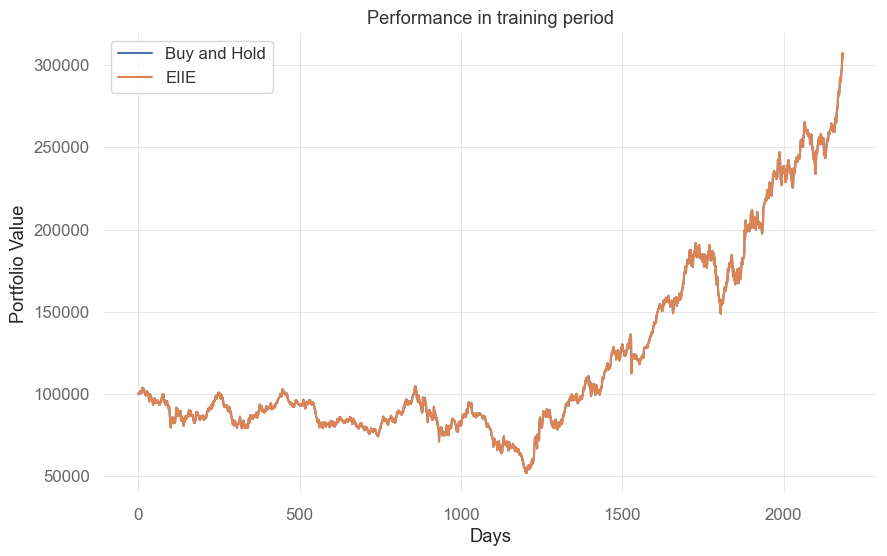

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["training"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()
plt.savefig(f"results/performance_in_training_episode{episodes}.png")
plt.show()

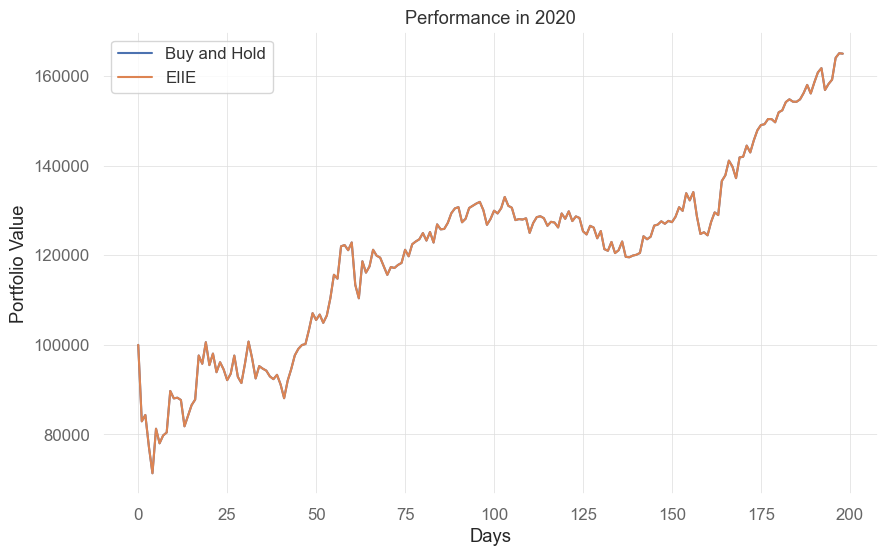

In [49]:
plt.plot(UBAH_results["2020"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2020"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2020")
plt.legend()
plt.savefig(f"results/performance_in_2020_episode{episodes}.png")
plt.show()

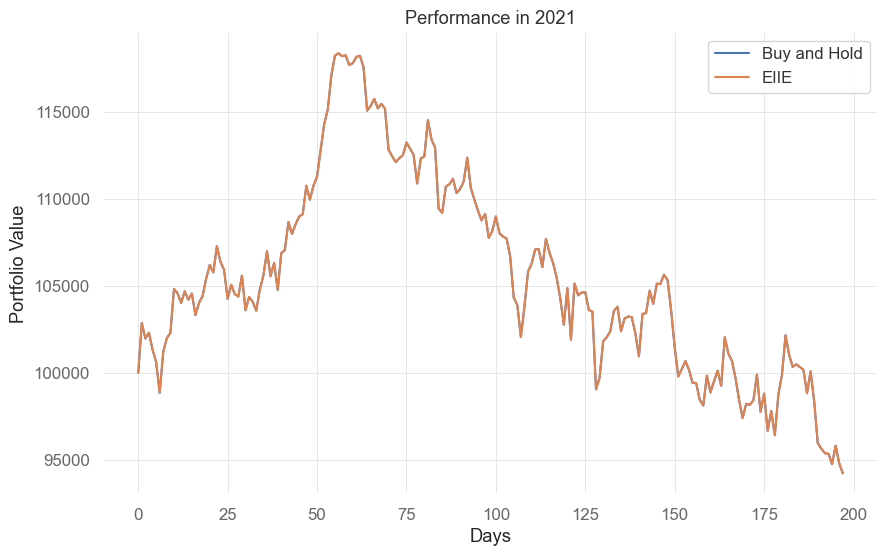

In [50]:
plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()
plt.savefig(f"results/performance_in_2021_episode{episodes}.png")
plt.show()

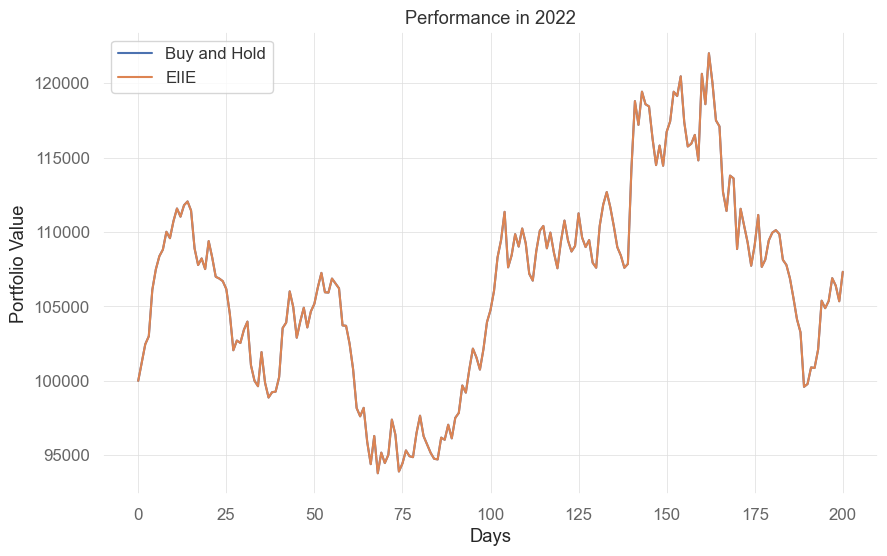

In [51]:
plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()
plt.savefig(f"results/performance_in_2022_episode{episodes}.png")
plt.show()

## Question: 为什么在训练400个episode之后，EIIE的曲线与Buy and Hold的曲线完全重合了呢